In [1]:
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
IS_PRE = False

E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if IS_PRE:
    model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device="cuda")
    queries = [
        "Artiklen undersøger kunstig intelligens og machine learning.",
        "Teksten handler om AI-politik, regulering og etik.",
        "Dette dokument beskriver AI-teknologi, GPT og automatisering.",
        "Artiklen diskuterer brugen af robotter og generativ AI."
    ]

    keywords_query = ["AI", "kunstig intelligens", "maskinlæring", "dyb læring", "neural netværk", "automatisering",
                      "robotik", "dataanalyse", "algoritme", "intelligente systemer", "GPT", "OPENAI", "LLM", "chatbot",
                      "sprogmodel", "generativ AI", "AI-assistent", "AI-drevet", "computer vision",
                      "naturlig sprogbehandling",
                      "AI-platform", "AI-teknologi", "AI-forskning", "AI-innovation", "AI-applikationer", "AI-løsninger",
                      "AI-udvikling", "AI-sikkerhed", "AI-etik", "AI-regulering", "AI-politik", "AI-strategi",
                      "AI-investering",
                      "AI-startup", "AI-industrien", "AI-marked", "AI-trends", "AI-fremtid", "robotter",
                      "automatiserede systemer",
                      "intelligente maskiner", "AI-integration", "AI-implementering", "AI-optimering", "AI-overvågning", ]
    import re

    emb = np.load("../results/01_embeddings.npy")
    df = pd.read_csv("../results/00_raw_data.csv")
    ai_vec = model.encode(queries, normalize_embeddings=True)
    query_vec = np.mean(ai_vec, axis=0)

    true_score = util.cos_sim(emb, ai_vec)
    ai_final_score = true_score.mean(dim=1)
    # 1) 先把 keywords 分成 “短词” 和 “长词”
    short_keywords = [kw for kw in keywords_query
                      if len(kw) <= 3 and " " not in kw]
    long_keywords = [kw for kw in keywords_query
                     if kw not in short_keywords]

    short_patterns = {
        kw: re.compile(r"\b" + re.escape(kw.lower()) + r"\b", flags=re.IGNORECASE)
        for kw in short_keywords
    }

    keyword_scores = []

    for index, row in df.iterrows():
        text = row['plain_text']
        text_lower = text.lower()

        score = 0
        score += sum(
            1 for kw in long_keywords
            if kw.lower() in text_lower
        )

        score += sum(
            1 for kw, pattern in short_patterns.items()
            if pattern.search(text_lower)
        )

        keyword_scores.append(score)

    keyword_scores = np.array(keyword_scores)
    # assign to column
    df['keyword_score'] = keyword_scores

    df["ai_score"] = ai_final_score

    df["is_ai"] = df["ai_score"] > 0
    # and keyword score > 0
    df["is_ai"] = df["is_ai"] & (df["keyword_score"] > 0)

    ai_score_df = df

In [3]:
df1 =  pd.read_csv("../results/dk_news_2016_2024_ai_shard_1_v2.csv.tmp")
df2 =  pd.read_csv("../results/dk_news_2016_2024_ai_shard_2_v2.csv.tmp")
df3 =  pd.read_csv("../results/dk_news_2016_2024_ai_shard_3_v2.csv.tmp")
df4 =  pd.read_csv("../results/dk_news_2016_2024_ai_shard_0_v2.csv.tmp")
m_df1 = pd.read_csv("../results/missing_shard_0.csv")
m_df2 = pd.read_csv("../results/missing_shard_1.csv")
m_df3 = pd.read_csv("../results/missing_shard_2.csv")
m_df4 = pd.read_csv("../results/missing_shard_3.csv")
df = pd.concat([df1, df2, df3,df4,m_df1,m_df2,m_df3,m_df4], axis=0)
print(df.shape)
# df = pd.to_csv('dk_news_2016_2024_ai_shard_v2.csv')
# drop duplicate orig_index row in df
df.drop_duplicates(subset='orig_index',inplace=True)
print(df.shape)
if not IS_PRE:
    ai_score_df = pd.read_csv("../results/02_ai_scores_v2.csv")
# concat previous_df ['ai_score', 'keyword_score'] to df based on orig_index to previous_df index
df = df.merge(ai_score_df[['ai_score', 'keyword_score']], left_on='orig_index', right_index=True, how='left')
print(df.shape)
df.dropna(inplace=True,subset=["is_ai_llm"])
print(df.shape)
print(df.columns)
df.describe()
# only keep year larger than 2015
df = df[pd.to_datetime(df["published_date"], errors='coerce').dt.year >= 2016]



C:\Users\qswwq\AppData\Local\Temp\ipykernel_31932\3906681387.py:1: DtypeWarning: Columns (9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_1_v2.csv.tmp")
C:\Users\qswwq\AppData\Local\Temp\ipykernel_31932\3906681387.py:2: DtypeWarning: Columns (9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_2_v2.csv.tmp")
C:\Users\qswwq\AppData\Local\Temp\ipykernel_31932\3906681387.py:3: DtypeWarning: Columns (9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_3_v2.csv.tmp")
C:\Users\qswwq\AppData\Local\Temp\ipykernel_31932\3906681387.py:4: DtypeWarning: Columns (9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_0_v2.csv.tm

(1590032, 15)
(1200456, 15)
(1200456, 17)
(810880, 17)
Index(['plain_text', 'published_date', 'title', 'tags', 'categories', 'author',
       'sitename', 'publisher', 'orig_index', 'is_ai_llm', 'ai_relevance_llm',
       'ai_topic_llm', 'ai_barrier_llm', 'ai_barrier_type_llm',
       'ai_barrier_summary_llm', 'ai_score', 'keyword_score'],
      dtype='object')


Shape: (808890, 17)
Columns: ['plain_text', 'published_date', 'title', 'tags', 'categories', 'author', 'sitename', 'publisher', 'orig_index', 'is_ai_llm', 'ai_relevance_llm', 'ai_topic_llm', 'ai_barrier_llm', 'ai_barrier_type_llm', 'ai_barrier_summary_llm', 'ai_score', 'keyword_score']

=== Basic info ===
<class 'pandas.core.frame.DataFrame'>
Index: 808890 entries, 0 to 188479
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   plain_text              808890 non-null  object        
 1   published_date          808890 non-null  datetime64[ns]
 2   title                   808890 non-null  object        
 3   tags                    190430 non-null  object        
 4   categories              318967 non-null  object        
 5   author                  719691 non-null  object        
 6   sitename                808890 non-null  object        
 7   publisher               808890 no

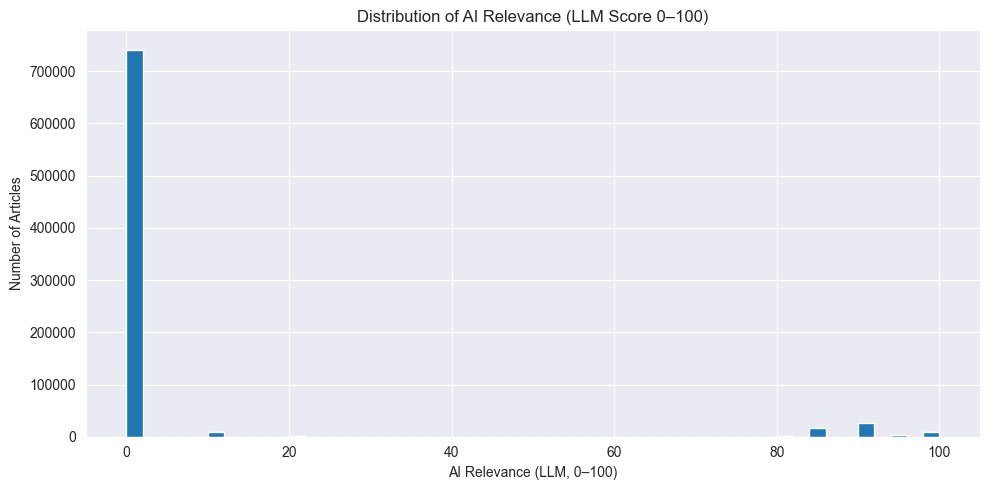

Saved: figures_ai_llm_overview\01_ai_relevance_distribution.png


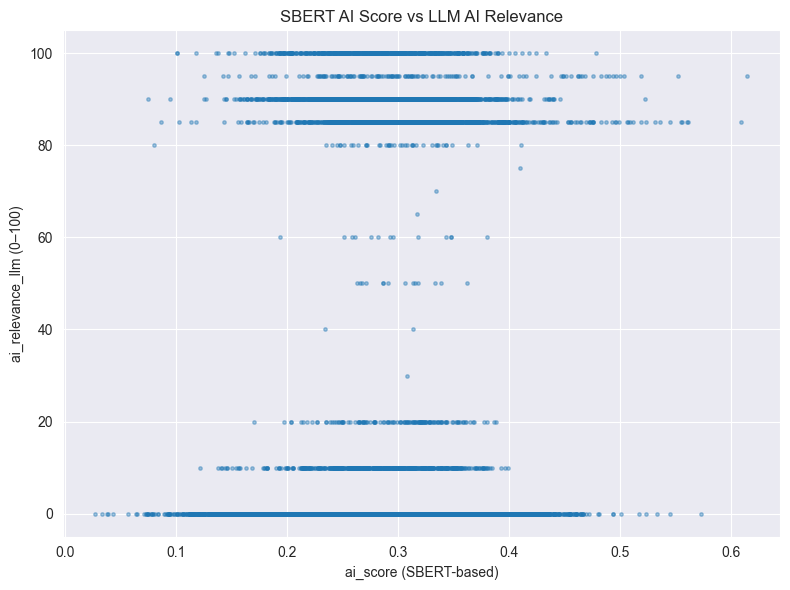

Saved: figures_ai_llm_overview\02_sbert_vs_llm_relevance.png


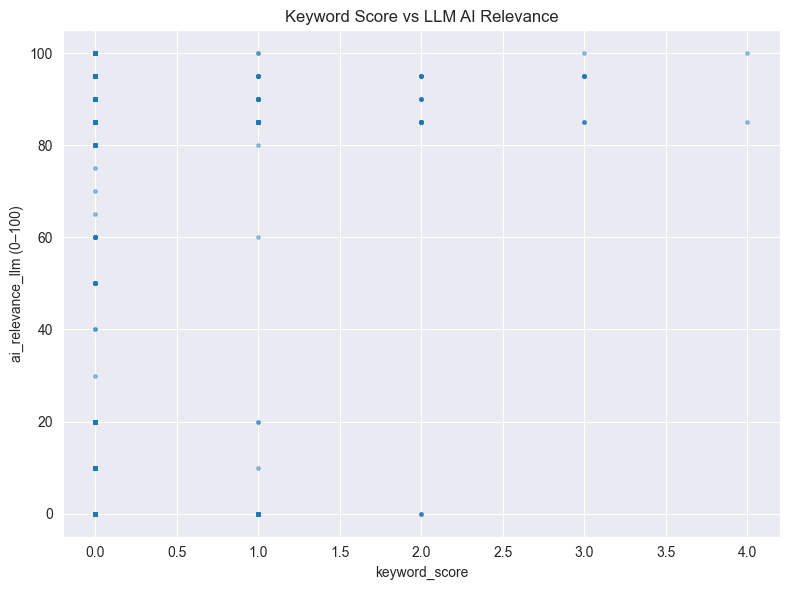

Saved: figures_ai_llm_overview\03_keyword_vs_llm_relevance.png


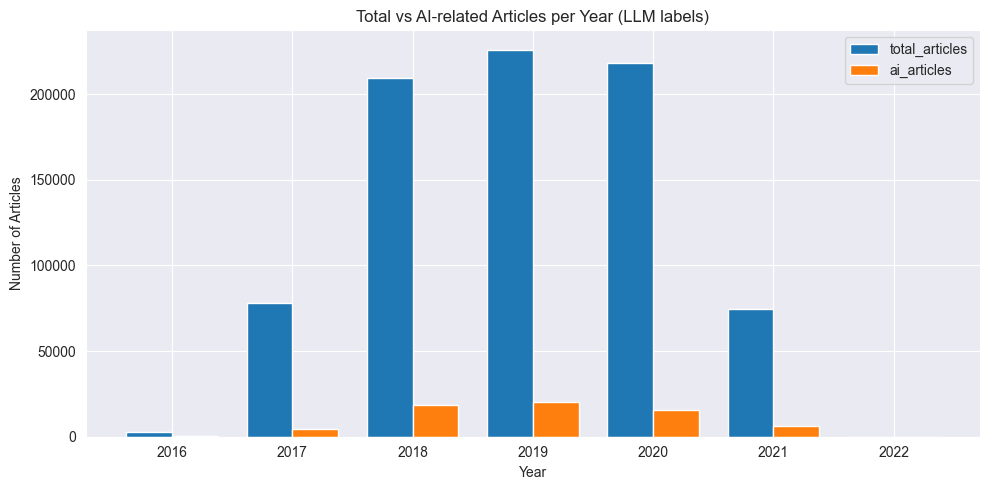

Saved: figures_ai_llm_overview\04_yearly_total_vs_ai.png


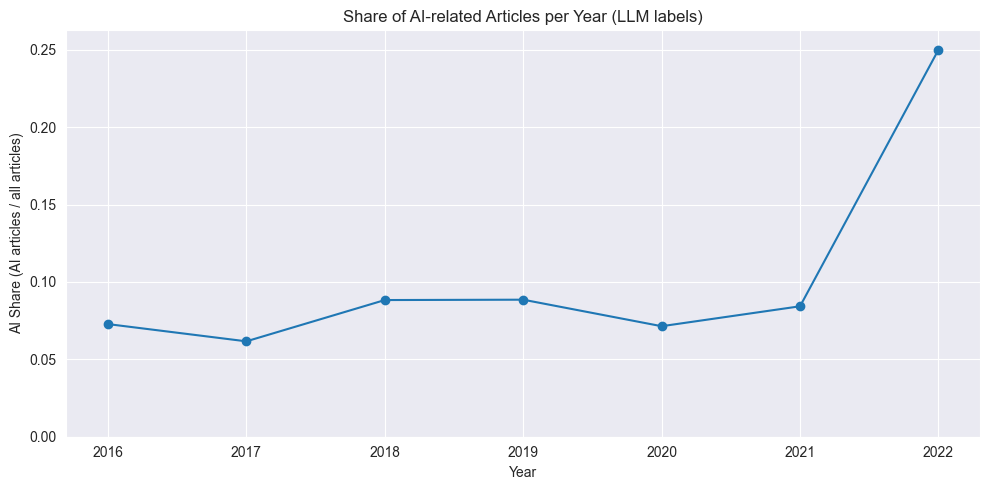

Saved: figures_ai_llm_overview\05_yearly_ai_share.png


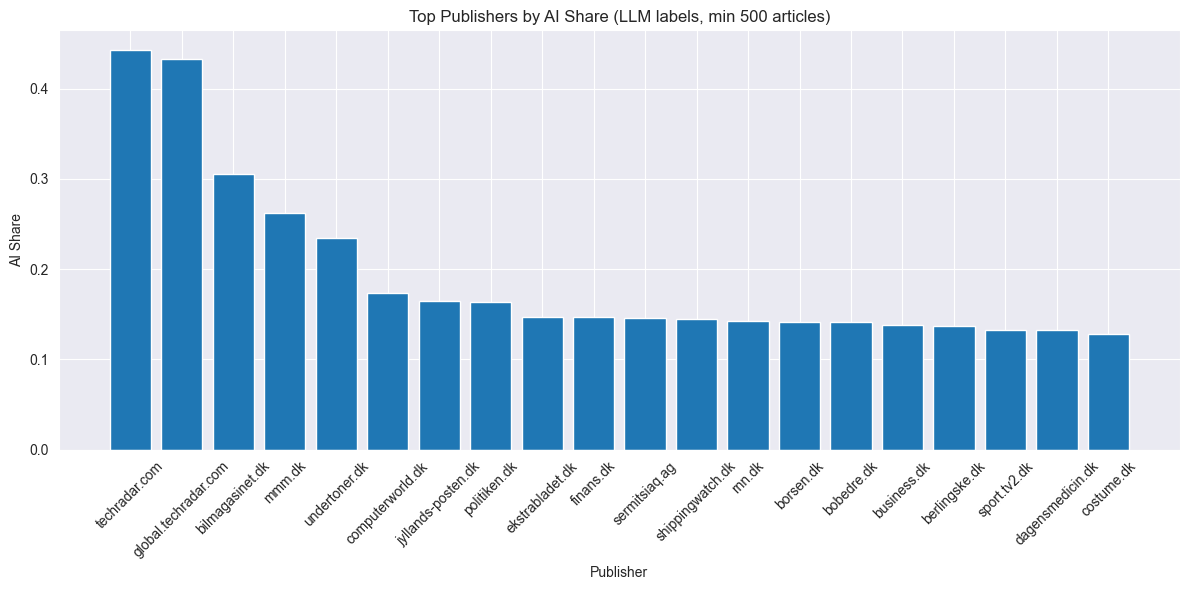

Saved: figures_ai_llm_overview\06_publisher_ai_share.png


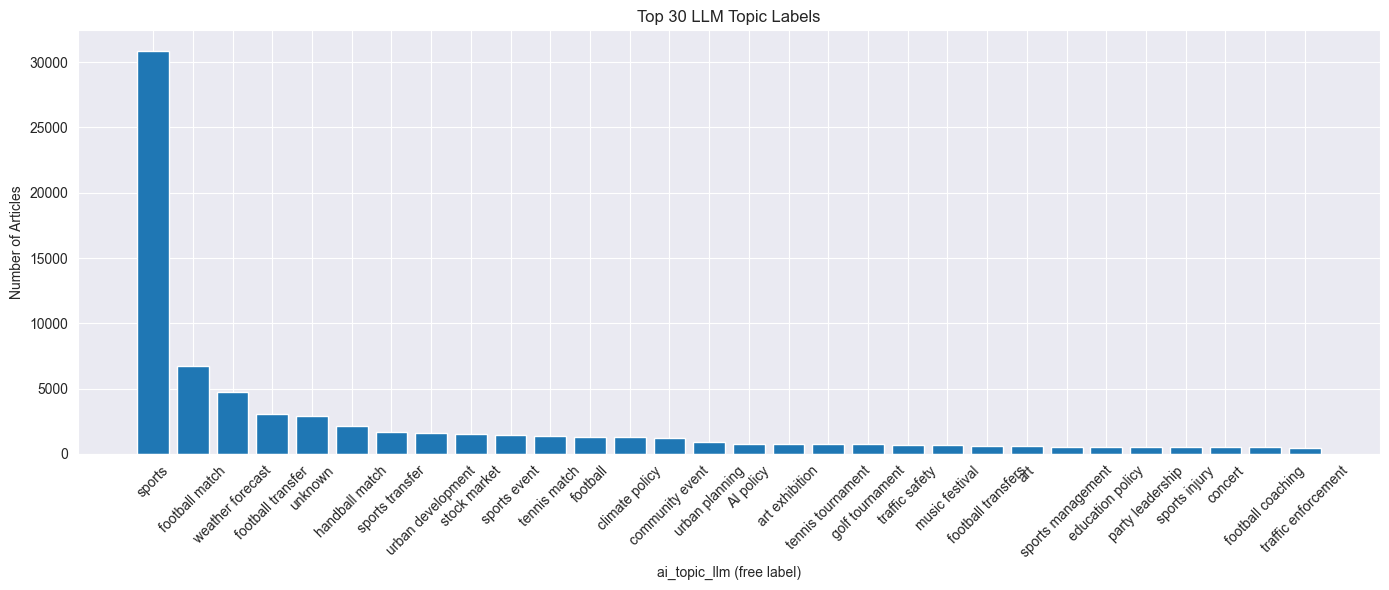

Saved: figures_ai_llm_overview\07_topic_distribution.png


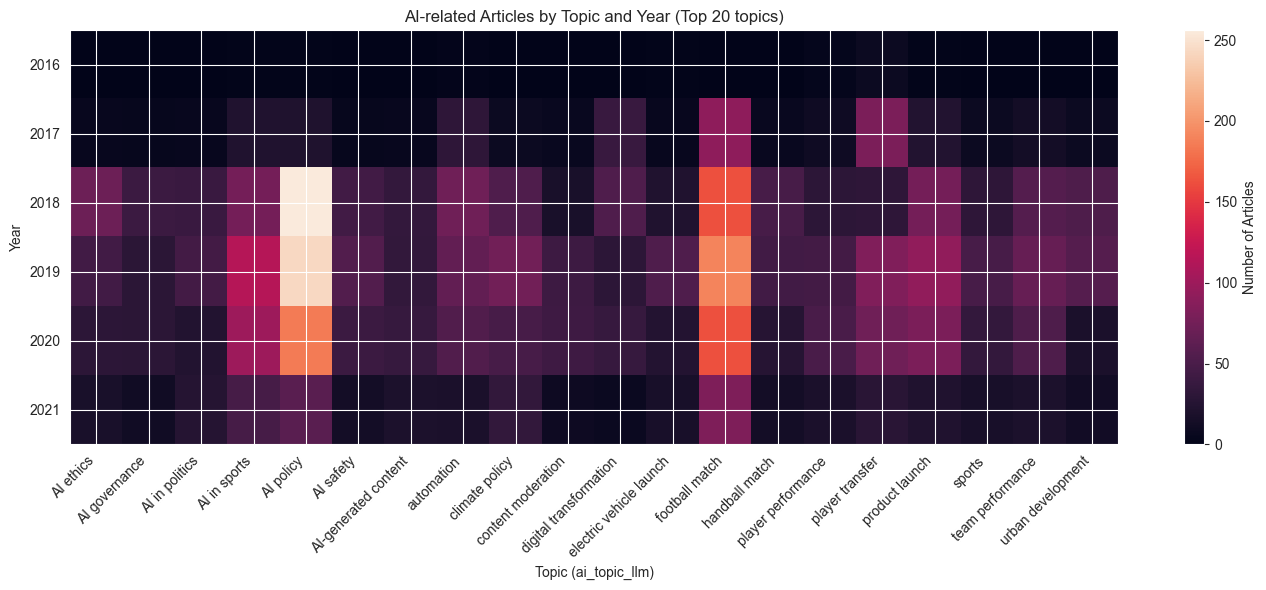

Saved: figures_ai_llm_overview\08_topic_year_heatmap.png


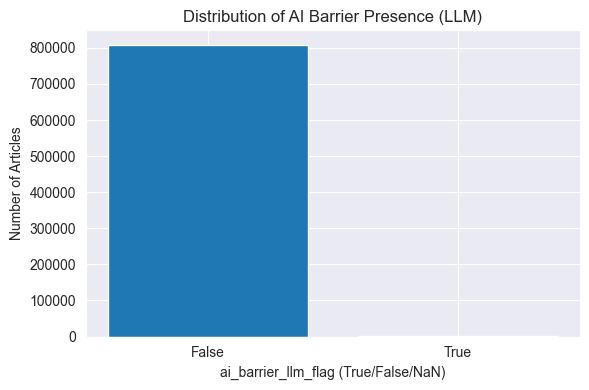

Saved: figures_ai_llm_overview\09_barrier_presence_distribution.png


C:\Users\qswwq\AppData\Local\Temp\ipykernel_31932\3628711017.py:119: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


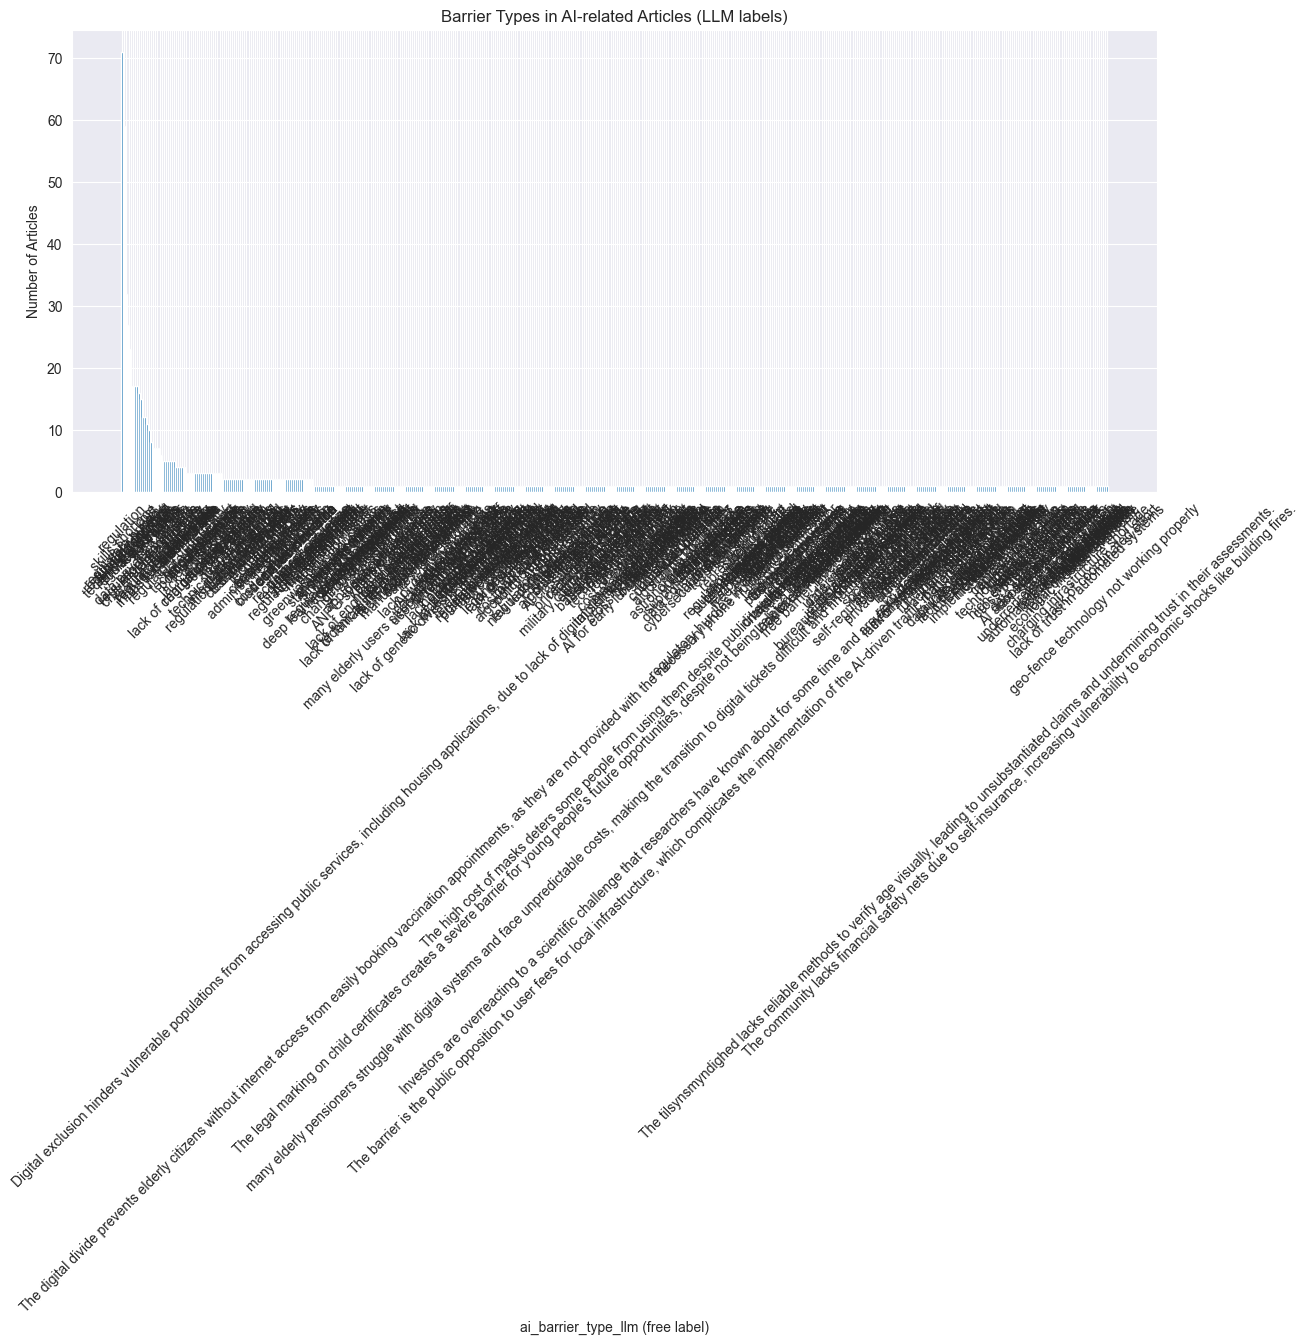

Saved: figures_ai_llm_overview\10_barrier_type_distribution.png


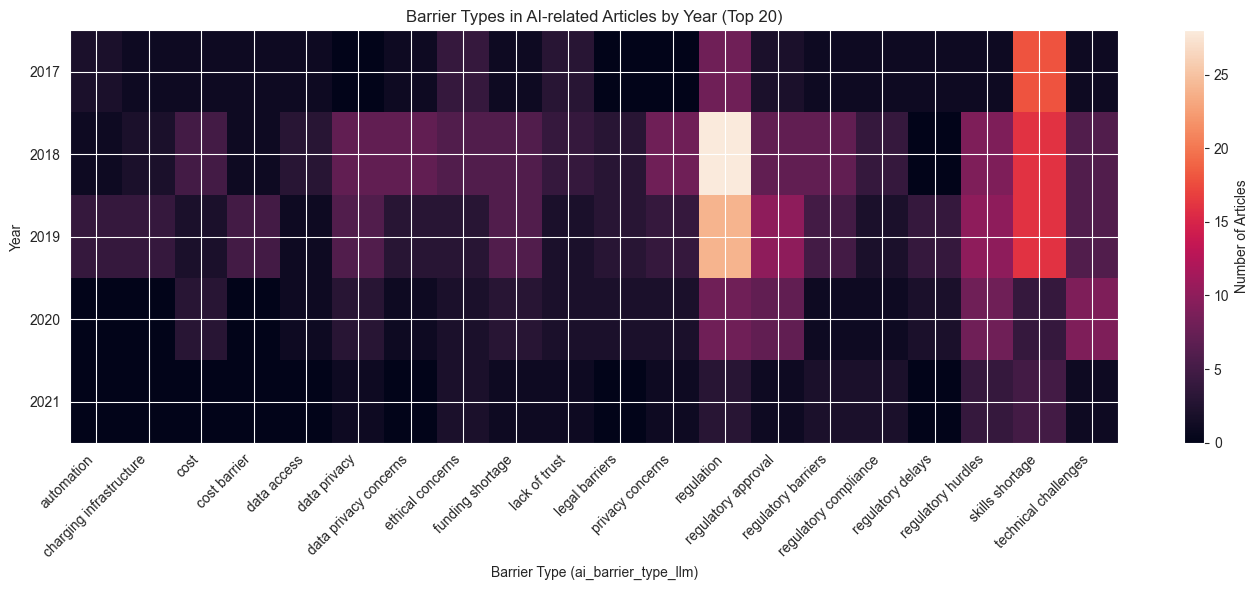

Saved: figures_ai_llm_overview\11_barrier_type_year_heatmap.png

All figures saved under: figures_ai_llm_overview


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# df1 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_1_v2.csv")
# df2 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_2_v2.csv")
# df3 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_3_v2.csv")
# df4 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_4_v2.csv")  # <- small fix: shard_4, not 3
# df = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)

# If not, uncomment and fix paths:
# df1 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_1_v2.csv")
# df2 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_2_v2.csv")
# df3 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_3_v2.csv")
# df4 =  pd.read_csv("results/dk_news_2016_2024_ai_shard_4_v2.csv")
# df = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Directory for figures (PNG)
FIG_DIR = "../figures_ai_llm_overview"
os.makedirs(FIG_DIR, exist_ok=True)

# =====================================================
# 1. Basic cleaning & helpers
# =====================================================

# 1.1 Parse dates and extract year
if "published_date" in df.columns:
    df["published_date"] = pd.to_datetime(df["published_date"], errors="coerce")
    df["year"] = df["published_date"].dt.year
else:
    df["year"] = np.nan


def to_bool_series(series: pd.Series) -> pd.Series:
    """
    Robust boolean conversion:
    - true:  True, 1, "1", "true", "True", "ja", "yes"
    - false: False, 0, "0", "false", "False", "nej", "no"
    - others: NaN
    """
    s = series.astype(str).str.strip().str.lower()
    true_vals = {"1", "true", "ja", "yes"}
    false_vals = {"0", "false", "nej", "no"}

    def _map_val(v: str):
        if v in true_vals:
            return True
        if v in false_vals:
            return False
        return np.nan

    return s.map(_map_val)


# 1.2 Convert LLM AI flag to boolean
if "is_ai_llm" in df.columns:
    df["is_ai_llm_flag"] = to_bool_series(df["is_ai_llm"])
else:
    df["is_ai_llm_flag"] = np.nan

if "is_ai" in df.columns:
    df["is_ai_flag"] = to_bool_series(df["is_ai"])
else:
    df["is_ai_flag"] = np.nan

# 1.3 Ensure relevance score is numeric
if "ai_relevance_llm" in df.columns:
    df["ai_relevance_llm"] = pd.to_numeric(df["ai_relevance_llm"], errors="coerce")

# 1.4 Ensure barrier flag is boolean
if "ai_barrier_llm" in df.columns:
    df["ai_barrier_llm_flag"] = to_bool_series(df["ai_barrier_llm"])
else:
    df["ai_barrier_llm_flag"] = np.nan

# =====================================================
# 2. Basic descriptive statistics (printed)
# =====================================================

print("\n=== Basic info ===")
print(df.info())

print("\n=== Missing value ratio per column ===")
missing_ratio = df.isna().mean().sort_values(ascending=False)
print(missing_ratio)

print("\n=== Numeric describe ===")
print(df.describe())

print("\n=== Example topic / barrier columns head ===")
cols_preview = [
    "orig_index",
    "published_date",
    "sitename",
    "publisher",
    "is_ai_llm_flag",
    "ai_relevance_llm",
    "ai_topic_llm",
    "ai_barrier_llm_flag",
    "ai_barrier_type_llm",
]
cols_preview = [c for c in cols_preview if c in df.columns]
print(df[cols_preview].head(10))


# =====================================================
# Plot helpers
# =====================================================


def _save_show_close(fig: plt.Figure, filename: str, dpi: int = 200):
    """Save to FIG_DIR as PNG, show in notebook, then close to free memory."""
    out_path = os.path.join(FIG_DIR, filename)
    fig.tight_layout()
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", out_path)


# =====================================================
# 3. Distribution of AI relevance scores (hist)
# =====================================================

if "ai_relevance_llm" in df.columns:
    x = df["ai_relevance_llm"].dropna()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(x, bins=50)
    ax.set_title("Distribution of AI Relevance (LLM Score 0–100)")
    ax.set_xlabel("AI Relevance (LLM, 0–100)")
    ax.set_ylabel("Number of Articles")
    _save_show_close(fig, "01_ai_relevance_distribution.png")

# =====================================================
# 4. Relationship: ai_score / keyword_score vs LLM relevance (scatter)
# =====================================================

MAX_POINTS_SCATTER = 50_000
need_cols = [c for c in ["ai_relevance_llm", "ai_score", "keyword_score"] if c in df.columns]
if "ai_relevance_llm" in need_cols:
    scatter_df = df[need_cols].copy().dropna()
    if len(scatter_df) > MAX_POINTS_SCATTER:
        scatter_df = scatter_df.sample(MAX_POINTS_SCATTER, random_state=42)

    if "ai_score" in scatter_df.columns:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(scatter_df["ai_score"], scatter_df["ai_relevance_llm"], s=6, alpha=0.4)
        ax.set_title("SBERT AI Score vs LLM AI Relevance")
        ax.set_xlabel("ai_score (SBERT-based)")
        ax.set_ylabel("ai_relevance_llm (0–100)")
        _save_show_close(fig, "02_sbert_vs_llm_relevance.png")

    if "keyword_score" in scatter_df.columns:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(scatter_df["keyword_score"], scatter_df["ai_relevance_llm"], s=6, alpha=0.4)
        ax.set_title("Keyword Score vs LLM AI Relevance")
        ax.set_xlabel("keyword_score")
        ax.set_ylabel("ai_relevance_llm (0–100)")
        _save_show_close(fig, "03_keyword_vs_llm_relevance.png")

# =====================================================
# 5. Yearly trends: total vs AI vs AI share
# =====================================================

if "year" in df.columns and "orig_index" in df.columns:
    if "is_ai_llm_flag" in df.columns:
        yearly = (
            df.groupby("year", dropna=True)
            .agg(
                total_articles=("orig_index", "count"),
                ai_articles=("is_ai_llm_flag", lambda s: s.fillna(False).astype(int).sum()),
            )
            .reset_index()
        )
    else:
        yearly = df.groupby("year", dropna=True).agg(total_articles=("orig_index", "count")).reset_index()
        yearly["ai_articles"] = 0

    yearly["ai_share"] = np.where(
        yearly["total_articles"] > 0, yearly["ai_articles"] / yearly["total_articles"], np.nan
    )

    # 5.1 Total vs AI articles per year (grouped bars)
    fig, ax = plt.subplots(figsize=(10, 5))
    years = yearly["year"].astype(int).tolist()
    x = np.arange(len(years))
    width = 0.38
    ax.bar(x - width / 2, yearly["total_articles"], width=width, label="total_articles")
    ax.bar(x + width / 2, yearly["ai_articles"], width=width, label="ai_articles")
    ax.set_title("Total vs AI-related Articles per Year (LLM labels)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of Articles")
    ax.set_xticks(x)
    ax.set_xticklabels(years, rotation=0)
    ax.legend()
    _save_show_close(fig, "04_yearly_total_vs_ai.png")

    # 5.2 AI share per year (line)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(yearly["year"], yearly["ai_share"], marker="o")
    ax.set_title("Share of AI-related Articles per Year (LLM labels)")
    ax.set_xlabel("Year")
    ax.set_ylabel("AI Share (AI articles / all articles)")
    if np.isfinite(np.nanmax(yearly["ai_share"])):
        ax.set_ylim(0, max(0.05, np.nanmax(yearly["ai_share"]) * 1.05))
    _save_show_close(fig, "05_yearly_ai_share.png")

# =====================================================
# 6. AI share per publisher
# =====================================================

if "publisher" in df.columns and "orig_index" in df.columns and "is_ai_llm_flag" in df.columns:
    tmp = df[["publisher", "orig_index", "is_ai_llm_flag"]].copy()
    tmp["ai_int"] = tmp["is_ai_llm_flag"].fillna(False).astype(int)

    publisher_stats = (
        tmp.groupby("publisher")
        .agg(total_articles=("orig_index", "count"), ai_articles=("ai_int", "sum"))
        .reset_index()
    )
    publisher_stats["ai_share"] = publisher_stats["ai_articles"] / publisher_stats["total_articles"]

    MIN_ARTICLES = 500
    publisher_stats = publisher_stats[publisher_stats["total_articles"] >= MIN_ARTICLES]
    publisher_stats = publisher_stats.sort_values("ai_share", ascending=False).head(20)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(publisher_stats["publisher"], publisher_stats["ai_share"])
    ax.set_title("Top Publishers by AI Share (LLM labels, min 500 articles)")
    ax.set_xlabel("Publisher")
    ax.set_ylabel("AI Share")
    ax.tick_params(axis="x", rotation=45)
    _save_show_close(fig, "06_publisher_ai_share.png")

# =====================================================
# 7. Topic distribution (ai_topic_llm)
# =====================================================

if "ai_topic_llm" in df.columns:
    topic_counts = (
        df["ai_topic_llm"]
        .astype(str)
        .str.strip()
        .replace("", np.nan)
        .dropna()
        .value_counts()
        .reset_index()
    )
    topic_counts.columns = ["ai_topic_llm", "count"]
    topic_counts = topic_counts[~topic_counts["ai_topic_llm"].str.lower().isin(["none", "nan", "other"])]

    TOP_N_TOPICS = 30
    topic_counts_top = topic_counts.head(TOP_N_TOPICS)

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(topic_counts_top["ai_topic_llm"], topic_counts_top["count"])
    ax.set_title(f"Top {TOP_N_TOPICS} LLM Topic Labels")
    ax.set_xlabel("ai_topic_llm (free label)")
    ax.set_ylabel("Number of Articles")
    ax.tick_params(axis="x", rotation=45)
    _save_show_close(fig, "07_topic_distribution.png")

# =====================================================
# 8. Topic × Year heatmap
# =====================================================

if {"ai_topic_llm", "year", "is_ai_llm_flag", "orig_index"}.issubset(df.columns):
    topic_year = (
        df[df["is_ai_llm_flag"] == True]
        .groupby(["year", "ai_topic_llm"])
        .agg(n=("orig_index", "count"))
        .reset_index()
    )

    top_topics = (
        topic_year.groupby("ai_topic_llm")["n"].sum().sort_values(ascending=False).head(20).index.tolist()
    )
    topic_year = topic_year[topic_year["ai_topic_llm"].isin(top_topics)]
    heat = topic_year.pivot_table(index="year", columns="ai_topic_llm", values="n", fill_value=0)

    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(heat.values, aspect="auto")
    ax.set_title("AI-related Articles by Topic and Year (Top 20 topics)")
    ax.set_xlabel("Topic (ai_topic_llm)")
    ax.set_ylabel("Year")
    ax.set_xticks(np.arange(len(heat.columns)))
    ax.set_xticklabels(heat.columns.tolist(), rotation=45, ha="right")
    ax.set_yticks(np.arange(len(heat.index)))
    ax.set_yticklabels(heat.index.astype(int).tolist())
    fig.colorbar(im, ax=ax, label="Number of Articles")
    _save_show_close(fig, "08_topic_year_heatmap.png")

# =====================================================
# 9. Barrier analysis
# =====================================================

# 9.1 Barrier presence distribution
if "ai_barrier_llm_flag" in df.columns:
    barrier_counts = df["ai_barrier_llm_flag"].value_counts(dropna=False)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(barrier_counts.index.astype(str), barrier_counts.values)
    ax.set_title("Distribution of AI Barrier Presence (LLM)")
    ax.set_xlabel("ai_barrier_llm_flag (True/False/NaN)")
    ax.set_ylabel("Number of Articles")
    _save_show_close(fig, "09_barrier_presence_distribution.png")

# 9.2 Barrier type distribution (for AI-related + has_barrier)
if {"ai_barrier_type_llm", "is_ai_llm_flag", "ai_barrier_llm_flag"}.issubset(df.columns):
    barrier_type_df = df[(df["is_ai_llm_flag"] == True) & (df["ai_barrier_llm_flag"] == True)].copy()

    barrier_type_counts = (
        barrier_type_df["ai_barrier_type_llm"]
        .astype(str)
        .str.strip()
        .replace("", np.nan)
        .dropna()
        .value_counts()
        .reset_index()
    )
    barrier_type_counts.columns = ["ai_barrier_type_llm", "count"]

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(barrier_type_counts["ai_barrier_type_llm"], barrier_type_counts["count"])
    ax.set_title("Barrier Types in AI-related Articles (LLM labels)")
    ax.set_xlabel("ai_barrier_type_llm (free label)")
    ax.set_ylabel("Number of Articles")
    ax.tick_params(axis="x", rotation=45)
    _save_show_close(fig, "10_barrier_type_distribution.png")

# 9.3 Barrier type × Year heatmap
if {"ai_barrier_type_llm", "year", "is_ai_llm_flag", "ai_barrier_llm_flag", "orig_index"}.issubset(df.columns):
    barrier_year = (
        df[(df["is_ai_llm_flag"] == True) & (df["ai_barrier_llm_flag"] == True)]
        .groupby(["year", "ai_barrier_type_llm"])
        .agg(n=("orig_index", "count"))
        .reset_index()
    )

    top_barriers = (
        barrier_year.groupby("ai_barrier_type_llm")["n"].sum().sort_values(ascending=False).head(20).index.tolist()
    )
    barrier_year = barrier_year[barrier_year["ai_barrier_type_llm"].isin(top_barriers)]
    heat_b = barrier_year.pivot_table(index="year", columns="ai_barrier_type_llm", values="n", fill_value=0)

    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(heat_b.values, aspect="auto")
    ax.set_title("Barrier Types in AI-related Articles by Year (Top 20)")
    ax.set_xlabel("Barrier Type (ai_barrier_type_llm)")
    ax.set_ylabel("Year")
    ax.set_xticks(np.arange(len(heat_b.columns)))
    ax.set_xticklabels(heat_b.columns.tolist(), rotation=45, ha="right")
    ax.set_yticks(np.arange(len(heat_b.index)))
    ax.set_yticklabels(heat_b.index.astype(int).tolist())
    fig.colorbar(im, ax=ax, label="Number of Articles")
    _save_show_close(fig, "11_barrier_type_year_heatmap.png")

print("\nAll figures saved under:", FIG_DIR)



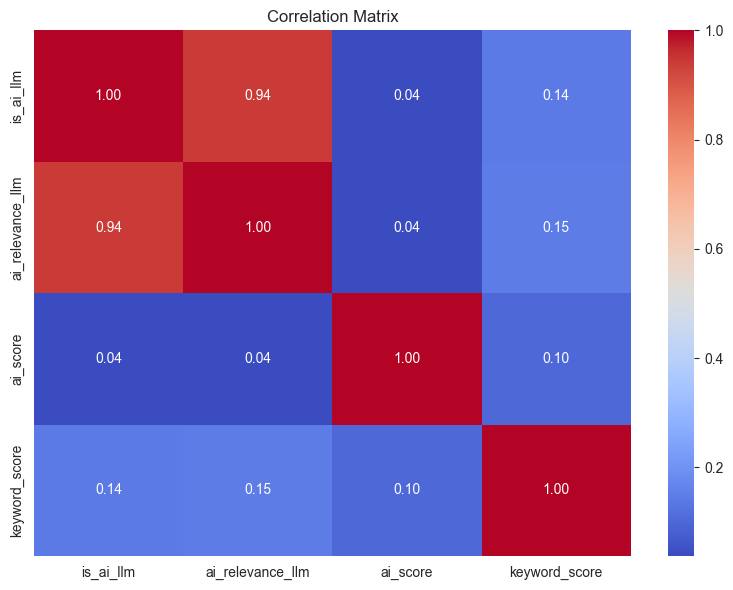

<Figure size 640x480 with 0 Axes>

In [5]:
# correlation matrix of is_ai_llm, ai_relevance_llm, ai_score, keyword_score, ai_barrier_llm_flag
corr_cols = [
    "is_ai_llm",
    "ai_relevance_llm",
    "ai_score",
    "keyword_score",
]
corr_df = df[corr_cols].copy()
corr_matrix = corr_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(FIG_DIR, "12_correlation_matrix.png"), bbox_inches="tight")

In [6]:
# using umap and hdbscan to cluster articles based on their embeddings and see if clusters correspond to ai_llm labels
from umap import UMAP
ai_df = df[df['is_ai_llm']]

emb = np.load("../results/01_embeddings.npy")
# emb select by df orig_index
emb = emb[ai_df["orig_index"].values]

reduced = UMAP(n_neighbors=15, min_dist=0.0, metric="cosine").fit_transform(emb)
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000, metric='euclidean')
labels = clusterer.fit_predict(reduced)
ai_df["cluster"] = labels


E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\qswwq\AppData\Local\Temp\ipykernel_31932\1188711850.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_df["cluster"] = labels


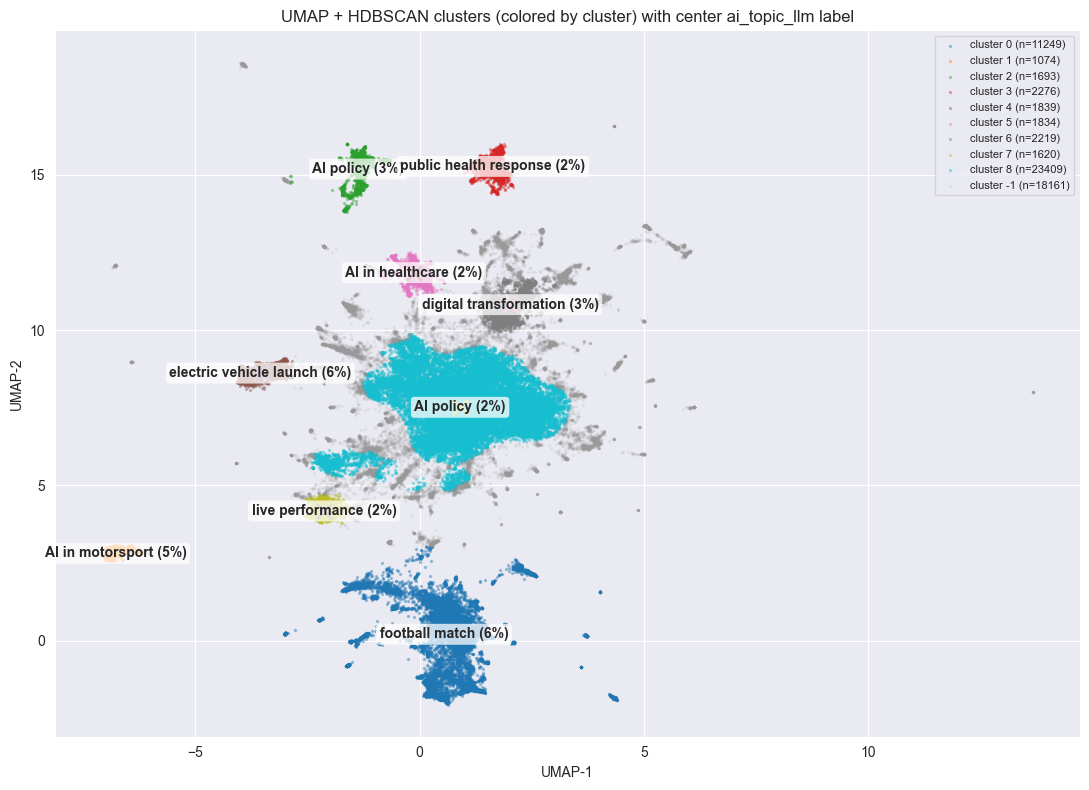

[-1  8  8 ...  0  0  8]


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Safety alignment
# -----------------------
ai_df = ai_df.copy().reset_index(drop=True)  # 重要：确保 reduced[i] 对应 ai_df.iloc[i]

CLUSTER_COL = "cluster"
TOPIC_COL = "ai_topic_llm"

assert reduced.shape[0] == len(ai_df), "reduced and ai_df length mismatch"
assert CLUSTER_COL in ai_df.columns, f"missing {CLUSTER_COL}"
assert TOPIC_COL in ai_df.columns, f"missing {TOPIC_COL}"

# -----------------------
# Plot params
# -----------------------
MAX_PTS = 200_000     # 点太多就抽样（60k不用抽也行）
RNG = 42
LABEL_MAX_CHARS = 26  # 标签太长截断
MIN_LABEL_N = 300     # 小簇不标注

N = len(ai_df)
idx = np.arange(N)
if N > MAX_PTS:
    idx = np.random.default_rng(RNG).choice(N, size=MAX_PTS, replace=False)

x = reduced[idx, 0]
y = reduced[idx, 1]
clusters = ai_df.loc[idx, CLUSTER_COL].to_numpy()

# unique clusters (keep -1 last)
uniq = np.unique(ai_df[CLUSTER_COL].to_numpy())
uniq = [c for c in uniq if c != -1] + ([-1] if -1 in uniq else [])

# color map for non-noise clusters
k = len([c for c in uniq if c != -1])
palette = plt.cm.tab10(np.linspace(0, 1, max(k, 3)))
color_map = {}
pi = 0
for c in uniq:
    if c == -1:
        color_map[c] = (0.6, 0.6, 0.6, 0.15)  # noise gray
    else:
        color_map[c] = palette[pi]
        pi += 1

# -----------------------
# Compute cluster centers + majority ai_topic_llm (on FULL data, not just sampled)
# -----------------------
centers = {}
labels_text = {}

for c in uniq:
    m_full = (ai_df[CLUSTER_COL].to_numpy() == c)
    if m_full.sum() == 0:
        continue

    cx = reduced[m_full, 0].mean()
    cy = reduced[m_full, 1].mean()
    centers[c] = (cx, cy)

    # majority topic label
    vc = ai_df.loc[m_full, TOPIC_COL].astype(str).value_counts()
    major = vc.index[0] if len(vc) else ""
    share = float(vc.iloc[0] / vc.sum()) if len(vc) else 0.0

    # shorten
    major2 = major.replace("\n", " ").strip()
    if len(major2) > LABEL_MAX_CHARS:
        major2 = major2[:LABEL_MAX_CHARS] + "…"

    labels_text[c] = f"{major2} ({share:.0%})"

# -----------------------
# Plot
# -----------------------
fig, ax = plt.subplots(figsize=(11, 8))

for c in uniq:
    m = (clusters == c)
    if m.sum() == 0:
        continue
    ax.scatter(
        x[m], y[m],
        s=2,
        alpha=0.35 if c != -1 else 0.10,
        c=[color_map[c]],
        label=f"cluster {c} (n={int((ai_df[CLUSTER_COL]==c).sum())})",
        rasterized=True
    )

ax.set_title("UMAP + HDBSCAN clusters (colored by cluster) with center ai_topic_llm label")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.legend(loc="best", fontsize=8, frameon=True)

# Center labels
for c in uniq:
    n_c = int((ai_df[CLUSTER_COL] == c).sum())
    if c == -1 or n_c < MIN_LABEL_N:
        continue
    cx, cy = centers[c]
    ax.scatter([cx], [cy], marker="x", s=120, linewidths=2)  # center marker
    ax.text(
        cx, cy,
        labels_text[c],
        fontsize=10, weight="bold",
        ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.75)
    )

fig.tight_layout()
fig.savefig("umap_hdbscan_clusters_with_center_topic.png", dpi=300, bbox_inches="tight")
plt.show()
# OUTPUT ALL cluster labels
print(labels)


In [8]:
import pandas as pd

CLUSTER_COL = "ai_relevance_llm"        # 你已存在的聚类列
TOPIC_COL   = "ai_topic_llm"   # 你要看的 topic 列（换成你的 topic 列名）
TOPN = 30                      # 输出前 TOPN 个 topic

# 1) 每个 cluster 的大小
cluster_counts = ai_df[CLUSTER_COL].value_counts(dropna=False)
print("Top clusters by size:")
print(cluster_counts.head(20))

# 2) 最大 cluster（通常是 -1）
n_l = 1
largest_cluster = cluster_counts.index[n_l]
largest_n = int(cluster_counts.iloc[n_l])
print(f"\nLargest cluster = {largest_cluster}, n = {largest_n}")

# 3) 最大 cluster 内部的 topic 分布
sub = ai_df[ai_df[CLUSTER_COL] == largest_cluster].copy()

topic_dist = (
    sub[TOPIC_COL]
    .fillna("NA")
    .astype(str)
    .value_counts()
    .reset_index()
)
topic_dist.columns = [TOPIC_COL, "count"]
topic_dist["share"] = topic_dist["count"] / topic_dist["count"].sum()

print(f"\nTopic distribution inside cluster {largest_cluster} (top {TOPN}):")
print(topic_dist.head(TOPN))

# 可选：保存
topic_dist.to_csv(f"results/topic_dist_cluster_{largest_cluster}.csv", index=False, encoding="utf-8-sig")
print(f"\nSaved: results/topic_dist_cluster_{largest_cluster}.csv")


Top clusters by size:
ai_relevance_llm
90.0     27171
85.0     16930
100.0     9352
10.0      8235
95.0      2446
80.0       704
60.0       251
50.0       204
70.0        31
75.0        18
40.0        10
30.0        10
20.0         4
65.0         3
0.0          2
45.0         1
97.0         1
27.0         1
Name: count, dtype: int64

Largest cluster = 85.0, n = 16930

Topic distribution inside cluster 85.0 (top 30):
               ai_topic_llm  count     share
0                automation    145  0.008565
1    digital transformation    116  0.006852
2          machine learning     89  0.005257
3          team performance     73  0.004312
4            football match     64  0.003780
5            climate policy     60  0.003544
6            product launch     55  0.003249
7        content moderation     52  0.003071
8         urban development     50  0.002953
9         digital education     41  0.002422
10          player transfer     41  0.002422
11     public health policy     39  0.00

In [9]:
count = df['ai_topic_llm'].str.contains('AI', case=False, na=False).sum()
print(count)

15146


In [10]:
df.columns

Index(['plain_text', 'published_date', 'title', 'tags', 'categories', 'author',
       'sitename', 'publisher', 'orig_index', 'is_ai_llm', 'ai_relevance_llm',
       'ai_topic_llm', 'ai_barrier_llm', 'ai_barrier_type_llm',
       'ai_barrier_summary_llm', 'ai_score', 'keyword_score', 'year',
       'is_ai_llm_flag', 'is_ai_flag', 'ai_barrier_llm_flag'],
      dtype='object')

[INFO] PCA to 50 dims on sample...
[INFO] Computing inertia for K: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
  k=   1 inertia=2.017e+04
  k=   2 inertia=1.893e+04
  k=   3 inertia=1.800e+04
  k=   4 inertia=1.695e+04
  k=   5 inertia=1.634e+04
  k=   6 inertia=1.580e+04
  k=   7 inertia=1.534e+04
  k=   8 inertia=1.496e+04
  k=   9 inertia=1.456e+04
  k=  10 inertia=1.439e+04
  k=  11 inertia=1.413e+04
  k=  12 inertia=1.403e+04
  k=  13 inertia=1.388e+04
  k=  14 inertia=1.374e+04
  k=  15 inertia=1.356e+04
  k=  16 inertia=1.338e+04
  k=  17 inertia=1.319e+04
  k=  18 inertia=1.309e+04
  k=  19 inertia=1.295e+04
  k=  20 inertia=1.284e+04
  k=  21 inertia=1.284e+04
  k=  22 inertia=1.279e+04
  k=  23 inertia=1.272e+04
  k=  24 inertia=1.260e+04
  k=  25 inertia=1.257e+04
  k=  26 inertia=1.251e+04
  k=  27 inertia=1.235e+04
  k=  28 inertia

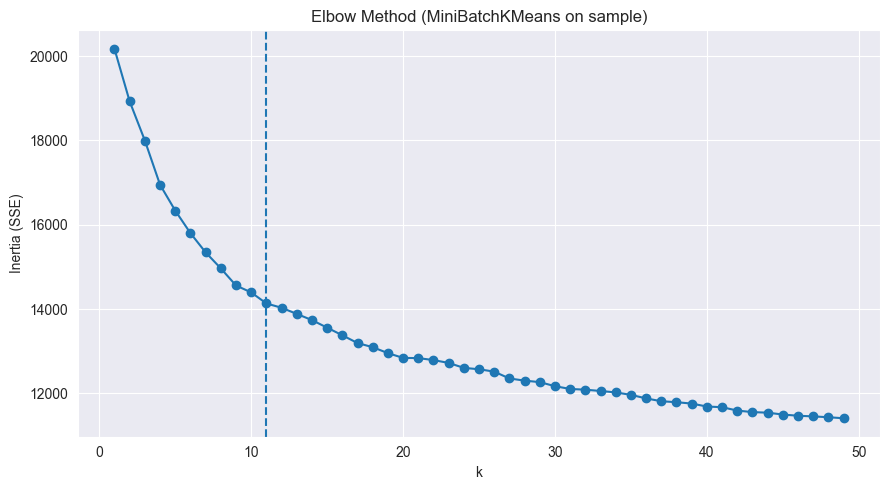

[OK] Saved plot: kmeans_elbow.png
[INFO] Transform full embeddings with PCA...
[INFO] Fitting final MiniBatchKMeans with k=11 on full data (N=65374)...

Top cluster sizes:
cluster_kmeans
9     14543
7      6428
8      6192
10     6008
1      5565
3      5340
6      4970
2      4678
5      4584
0      4041
4      3025
Name: count, dtype: int64

Smallest cluster sizes:
cluster_kmeans
9     14543
7      6428
8      6192
10     6008
1      5565
3      5340
6      4970
2      4678
5      4584
0      4041
4      3025
Name: count, dtype: int64

[OK] Saved labels: results/kmeans_cluster_labels.csv


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

# =========================
# CONFIG
# =========================
RNG = 42
SAMPLE_N = 200_000          # elbow computed on sample (increase if you can)
USE_PCA = True
PCA_DIM = 50                # good default for SBERT embeddings
K_LIST = list(range(1, 50, 1))  # try 20..500 step 20; adjust for your scale
BATCH_SIZE = 8192

FINAL_COL = "cluster_kmeans"

assert len(ai_df) == emb.shape[0], "ai_df and emb must be aligned (same N)"
ai_df = ai_df.reset_index(drop=True)

# =========================
# 1) Normalize embeddings (cosine-friendly)
# =========================
emb = np.asarray(emb, dtype=np.float32)
emb_norm = emb / (np.linalg.norm(emb, axis=1, keepdims=True) + 1e-12)

N = emb_norm.shape[0]
n_s = min(SAMPLE_N, N)
idx = np.random.default_rng(RNG).choice(N, size=n_s, replace=False)
X_s = emb_norm[idx]

# Optional PCA for speed/stability
if USE_PCA:
    print(f"[INFO] PCA to {PCA_DIM} dims on sample...")
    pca = PCA(n_components=PCA_DIM, random_state=RNG)
    X_s_pca = pca.fit_transform(X_s)
else:
    pca = None
    X_s_pca = X_s

# =========================
# 2) Elbow curve (inertia vs k)
# =========================
inertias = []
print("[INFO] Computing inertia for K:", K_LIST)
for k in K_LIST:
    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=RNG,
        batch_size=BATCH_SIZE,
        n_init="auto"
    )
    km.fit(X_s_pca)
    inertias.append(float(km.inertia_))
    print(f"  k={k:4d} inertia={inertias[-1]:.3e}")

# =========================
# 3) Auto elbow detection (max distance to line)
#    Works well on log(inertia).
# =========================
ks = np.array(K_LIST, dtype=float)
ys = np.log(np.array(inertias, dtype=float))

# line between first and last point
p1 = np.array([ks[0], ys[0]])
p2 = np.array([ks[-1], ys[-1]])

# distance from each point to the line (normalized)
# formula: |(p2-p1)x(p1-p)| / ||p2-p1||
v = p2 - p1
v_norm = np.linalg.norm(v) + 1e-12

dists = []
for k, y in zip(ks, ys):
    p = np.array([k, y])
    # 2D cross product magnitude
    cross = abs(v[0]*(p1[1]-p[1]) - v[1]*(p1[0]-p[0]))
    dists.append(cross / v_norm)

dists = np.array(dists)
best_i = int(np.argmax(dists))
best_k = int(ks[best_i])

print(f"\n[OK] Auto-elbow K = {best_k} (index={best_i})")

# Plot elbow
plt.figure(figsize=(9, 5))
plt.plot(K_LIST, inertias, marker="o")
plt.title("Elbow Method (MiniBatchKMeans on sample)")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.grid(True)
plt.axvline(best_k, linestyle="--")
plt.tight_layout()
plt.savefig("kmeans_elbow.png", dpi=300, bbox_inches="tight")
plt.show()
print("[OK] Saved plot: kmeans_elbow.png")

# =========================
# 4) Fit FINAL KMeans on ALL data
# =========================
if USE_PCA:
    print("[INFO] Transform full embeddings with PCA...")
    X_full = pca.transform(emb_norm)
else:
    X_full = emb_norm

print(f"[INFO] Fitting final MiniBatchKMeans with k={best_k} on full data (N={N})...")
final_km = MiniBatchKMeans(
    n_clusters=best_k,
    random_state=RNG,
    batch_size=BATCH_SIZE,
    n_init="auto"
)
labels_full = final_km.fit_predict(X_full)

ai_df[FINAL_COL] = labels_full

# Cluster size summary
sizes = ai_df[FINAL_COL].value_counts().sort_values(ascending=False)
print("\nTop cluster sizes:")
print(sizes.head(20))
print("\nSmallest cluster sizes:")
print(sizes.tail(20))

# Optional: save
ai_df[[FINAL_COL]].to_csv("results/kmeans_cluster_labels.csv", index=False)
print("\n[OK] Saved labels: results/kmeans_cluster_labels.csv")


Plotting Top-30 clusters: 65374 / 65374 (100.00%)


C:\Users\qswwq\AppData\Local\Temp\ipykernel_31932\2331364797.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(cats)) if len(cats) <= 20 else plt.cm.get_cmap("gist_ncar", len(cats))


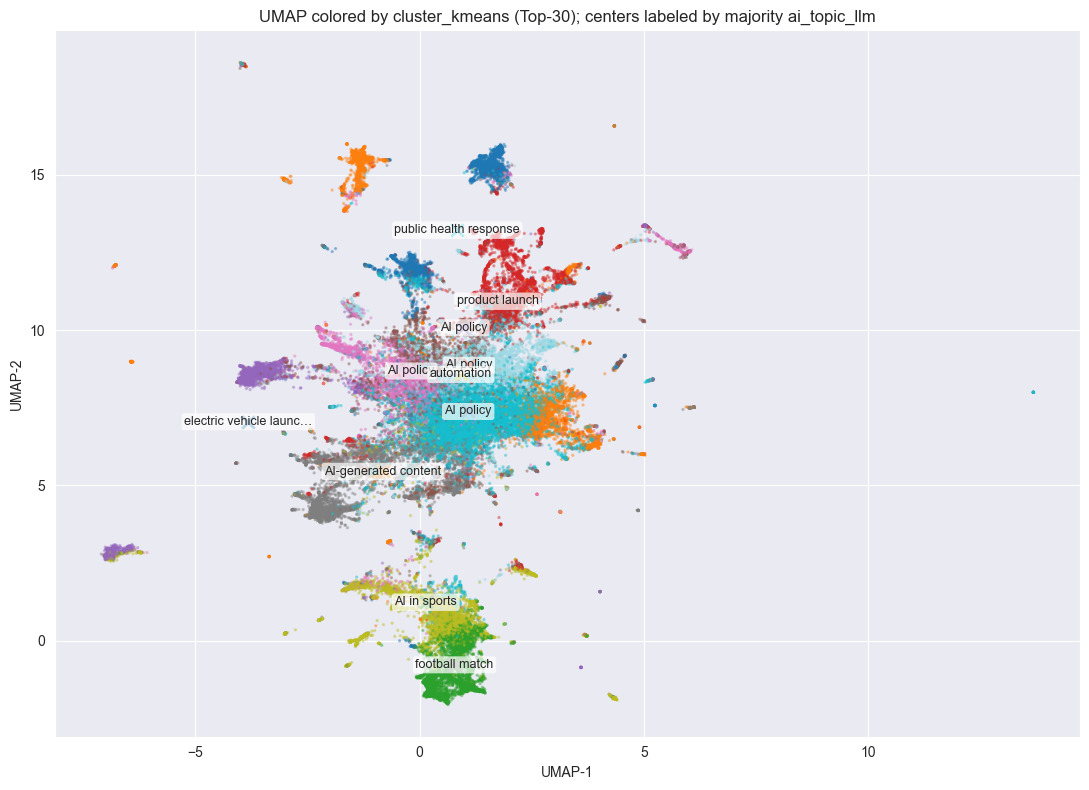

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------
# CONFIG
# -------------------
CLUSTER_COL = "cluster_kmeans"
TOPIC_COL   = "ai_topic_llm"

MAX_PTS = 200_000      # 散点抽样数（太大容易卡）
TOPK_PLOT = 30         # 只画最大的 Top-K 个簇（其余不画）——强烈推荐，否则太乱
TOPK_LABEL = 30        # 标注多少个簇的中心（建议与 TOPK_PLOT 一致）
MIN_LABEL_N = 200      # 小簇不标注（避免文字挤爆）
LABEL_MAX_CHARS = 22   # 标注文本截断长度

RNG = 42

# -------------------
# sanity
# -------------------
assert len(ai_df) == reduced.shape[0], "ai_df and reduced must align"
assert CLUSTER_COL in ai_df.columns, f"Missing {CLUSTER_COL}"
assert TOPIC_COL in ai_df.columns, f"Missing {TOPIC_COL}"

ai_df = ai_df.reset_index(drop=True)

# -------------------
# 1) pick Top-K clusters to plot (optional but recommended)
# -------------------
sizes = ai_df[CLUSTER_COL].value_counts()
top_clusters = sizes.head(TOPK_PLOT).index.to_numpy()

mask_top = ai_df[CLUSTER_COL].isin(top_clusters).to_numpy()
idx_all = np.where(mask_top)[0]
print(f"Plotting Top-{TOPK_PLOT} clusters: {len(idx_all)} / {len(ai_df)} ({len(idx_all)/len(ai_df):.2%})")

# sample only from selected clusters
idx = np.random.default_rng(RNG).choice(idx_all, size=min(MAX_PTS, len(idx_all)), replace=False)

x = reduced[idx, 0]
y = reduced[idx, 1]
c = ai_df.loc[idx, CLUSTER_COL].to_numpy()

# -------------------
# 2) compute cluster centers on FULL selected data (not just sample)
# -------------------
sub = ai_df.loc[idx_all, [CLUSTER_COL, TOPIC_COL]].copy()
sub["x"] = reduced[idx_all, 0]
sub["y"] = reduced[idx_all, 1]

# center (mean in reduced space)
centers = sub.groupby(CLUSTER_COL)[["x", "y"]].mean()

# majority ai_topic_llm per cluster (mode)
major_topic = (
    sub.groupby(CLUSTER_COL)[TOPIC_COL]
       .agg(lambda s: s.astype(str).value_counts().idxmax() if len(s) else "")
)

center_df = centers.join(major_topic.rename("major_topic"))
center_df["n_docs"] = sizes.loc[center_df.index].astype(int).values
center_df = center_df.sort_values("n_docs", ascending=False)

# choose which clusters to label
label_clusters = center_df.head(TOPK_LABEL).index.to_numpy()

# -------------------
# 3) plot
# -------------------
fig, ax = plt.subplots(figsize=(11, 8))

# Use categorical codes for coloring (works even if cluster ids are big numbers)
cat = pd.Series(c).astype("category")
codes = cat.cat.codes.to_numpy()
cats  = cat.cat.categories.to_numpy()

# discrete colormap with enough bins for TOPK_PLOT
cmap = plt.cm.get_cmap("tab20", len(cats)) if len(cats) <= 20 else plt.cm.get_cmap("gist_ncar", len(cats))

sc = ax.scatter(
    x, y,
    c=codes,
    s=2,
    alpha=0.35,
    cmap=cmap,
    rasterized=True
)

ax.set_title(f"UMAP colored by {CLUSTER_COL} (Top-{TOPK_PLOT}); centers labeled by majority {TOPIC_COL}")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")

# plot centers + labels
for cid in label_clusters:
    row = center_df.loc[cid]
    if row["n_docs"] < MIN_LABEL_N:
        continue

    cx, cy = row["x"], row["y"]
    topic = str(row["major_topic"]).strip().replace("\n", " ")
    if len(topic) > LABEL_MAX_CHARS:
        topic = topic[:LABEL_MAX_CHARS] + "…"

    ax.scatter([cx], [cy], marker="x", s=80, linewidths=2)  # center mark
    ax.text(
        cx, cy,
        f"{topic}",
        fontsize=9,
        ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
    )

fig.tight_layout()
fig.savefig("umap_kmeans_clusters_labeled_by_ai_topic_llm.png", dpi=300, bbox_inches="tight")
plt.show()


In [13]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [14]:
# 1) 先写入数值簇标签
ai_df["cluster"] = labels

# 2) 计算每个簇里出现最多的 ai_topic_llm（这就是你图里 labels_text 的逻辑）
cluster_to_topic = (
    ai_df.groupby("cluster")["ai_topic_llm"]
        .agg(lambda s: s.fillna("NA").astype(str).value_counts().idxmax())
)

# 3) 用这个“中心 topic”替换 cluster 列
ai_df["cluster"] = ai_df["cluster"].map(cluster_to_topic)

# 4) （可选）如果你想让噪声保持为 -1，而不是被替换成某个 topic，就加这一行
#     放在 map 之后，因为 map 会把 -1 也替换掉
ai_df.loc[labels == -1, "cluster"] = -1


In [15]:
cluster_to_topic
# ouput a random plain text from cluster 1


cluster
-1             product launch
 0             football match
 1           AI in motorsport
 2                  AI policy
 3     public health response
 4    electric vehicle launch
 5           AI in healthcare
 6     digital transformation
 7           live performance
 8                  AI policy
Name: ai_topic_llm, dtype: object

In [16]:
CLUSTER_COL = "cluster"
TEXT_COL = "plain_text"
TITLE_COL = "title"            # 没有就删掉
DATE_COL = "published_date"    # 没有就删掉

TARGET_CLUSTER = 'AI policy'          # <<< 改这里：例如 -1 或 "policy" 等
condition = ai_df['keyword_score']>1
sub = ai_df[(ai_df[CLUSTER_COL] == TARGET_CLUSTER)&condition]
print("cluster =", TARGET_CLUSTER, "n =", len(sub))

if len(sub) == 0:
    print("No rows in this cluster.")
else:
    i = np.random.default_rng(np.random.randint(0,100)).choice(sub.index, size=1)[0]
    row = ai_df.loc[i]

    # 可选：打印元信息
    if TITLE_COL in ai_df.columns:
        print("\nTITLE:", row[TITLE_COL])
    if DATE_COL in ai_df.columns:
        print("DATE :", row[DATE_COL])
    print("INDEX:", i)

    # 输出正文
    print("\nPLAIN_TEXT:\n")
    print(str(row[TEXT_COL]))
    print(row)

cluster = AI policy n = 81

TITLE: Lisbeth Bech Poulsen: Tag kontrollen over maskinerne tilbage
DATE : 2018-08-28 00:00:00
INDEX: 52576

PLAIN_TEXT:

De politiske beslutninger, der skal træffes de næste 15 år, bliver helt afgørende for, om Danmark ender som et dybt splittet samfund med en voldsomt stor underklasse og en lille eksklusiv elite. Den teknologiske udvikling sker nu med en sådan hast, at masser af almindelige mennesker med almindelige jobs risikerer at ende som overflødige borgere uden indflydelse på egen hverdag. Og de dramatiske forandringer fordrer et dramatisk politisk kursskifte, mener Lisbeth Bech Poulsen, finansordfører for SF og medforfatter til en ny debatbog, ’Oprør for fremtiden’, der udkommer i morgen. »Det her er et opråb, for vi ser i øjeblikket nogle klare faresignaler, som kun vil blive forstærket i takt med den teknologiske udvikling. Men vi er ikke maskinstormere. For os handler det om, at vi skal vende den nuværende udvikling til noget positivt, så vi ikke

In [17]:
# 列名里有空格的话用这种写法
CLUSTER_COL = "cluster"
KEYWORD_COL = "keyword_score"   # <<< 这里换成你真实的 keyword score 列名（看你写法像有空格）

# 1) 每个 cluster 的 keyword_score 均值
cluster_kw = (
    ai_df.groupby(CLUSTER_COL)[KEYWORD_COL]
         .mean()
         .sort_values(ascending=False)
)

# 2) 最大均值的 cluster
best_cluster = cluster_kw.index[0]
best_mean = cluster_kw.iloc[0]

print("Best cluster by mean keyword score:")
print("cluster =", best_cluster, "mean_keyword_score =", best_mean)

# 3) 可选：把 top 20 打出来
print("\nTop 20 clusters:")
print(cluster_kw.head(20))


Best cluster by mean keyword score:
cluster = digital transformation mean_keyword_score = 0.20279405137449302

Top 20 clusters:
cluster
digital transformation     0.202794
-1                         0.090579
AI in healthcare           0.044711
electric vehicle launch    0.025557
live performance           0.020988
AI policy                  0.020676
public health response     0.016696
football match             0.003556
AI in motorsport           0.002793
Name: keyword_score, dtype: float64


In [18]:
# 列名里有空格的话用这种写法
CLUSTER_COL = "cluster"
KEYWORD_COL = "keyword_score"   # <<< 这里换成你真实的 keyword score 列名（看你写法像有空格）

# 1) 每个 cluster 的 keyword_score 均值
cluster_kw = (
    ai_df.groupby(CLUSTER_COL)[KEYWORD_COL]
         .mean()
         .sort_values(ascending=False)
)

# 2) 最大均值的 cluster
best_cluster = cluster_kw.index[0]
best_mean = cluster_kw.iloc[0]

print("Best cluster by mean keyword score:")
print("cluster =", best_cluster, "mean_keyword_score =", best_mean)

# 3) 可选：把 top 20 打出来
print("\nTop 20 clusters:")
print(cluster_kw)

# output total rows that cluster by key_score>0.014
target_cluster = [x for x in cluster_kw.index if cluster_kw[x]>0.014]
print(target_cluster)
# locate rows in ai_df that belong to target_cluster
sub = ai_df[ai_df['cluster'].isin(target_cluster)]
sub.shape




Best cluster by mean keyword score:
cluster = digital transformation mean_keyword_score = 0.20279405137449302

Top 20 clusters:
cluster
digital transformation     0.202794
-1                         0.090579
AI in healthcare           0.044711
electric vehicle launch    0.025557
live performance           0.020988
AI policy                  0.020676
public health response     0.016696
football match             0.003556
AI in motorsport           0.002793
Name: keyword_score, dtype: float64
['digital transformation', -1, 'AI in healthcare', 'electric vehicle launch', 'live performance', 'AI policy', 'public health response']


(53051, 23)

In [19]:
CLUSTER_COL = "cluster"
KEYWORD_COL = "ai_score"   # <<< 这里换成你真实的 keyword score 列名（看你写法像有空格）

# 1) 每个 cluster 的 keyword_score 均值
cluster_kw = (
    sub.groupby(CLUSTER_COL)[KEYWORD_COL]
         .mean()
         .sort_values(ascending=False)
)

# 2) 最大均值的 cluster
best_cluster = cluster_kw.index[0]
best_mean = cluster_kw.iloc[0]

print("Best cluster by mean embedding similarity score :")
print("cluster =", best_cluster, "mean_similarity_score =", best_mean)

# 3) 可选：把 top 20 打出来
print("\nTop 20 clusters:")
print(cluster_kw)

# output total rows that cluster by key_score>0.014
target_cluster = [x for x in cluster_kw.index if cluster_kw[x]>0.267]
print(target_cluster)
# locate rows in ai_df that belong to target_cluster
sub2 = ai_df[ai_df['cluster'].isin(target_cluster)]
sub2.shape

Best cluster by mean embedding similarity score :
cluster = digital transformation mean_similarity_score = 0.36629968949526814

Top 20 clusters:
cluster
digital transformation     0.366300
AI policy                  0.308807
electric vehicle launch    0.308029
-1                         0.299713
AI in healthcare           0.283329
live performance           0.253121
public health response     0.244001
Name: ai_score, dtype: float64
['digital transformation', 'AI policy', 'electric vehicle launch', -1, 'AI in healthcare']


(49155, 23)

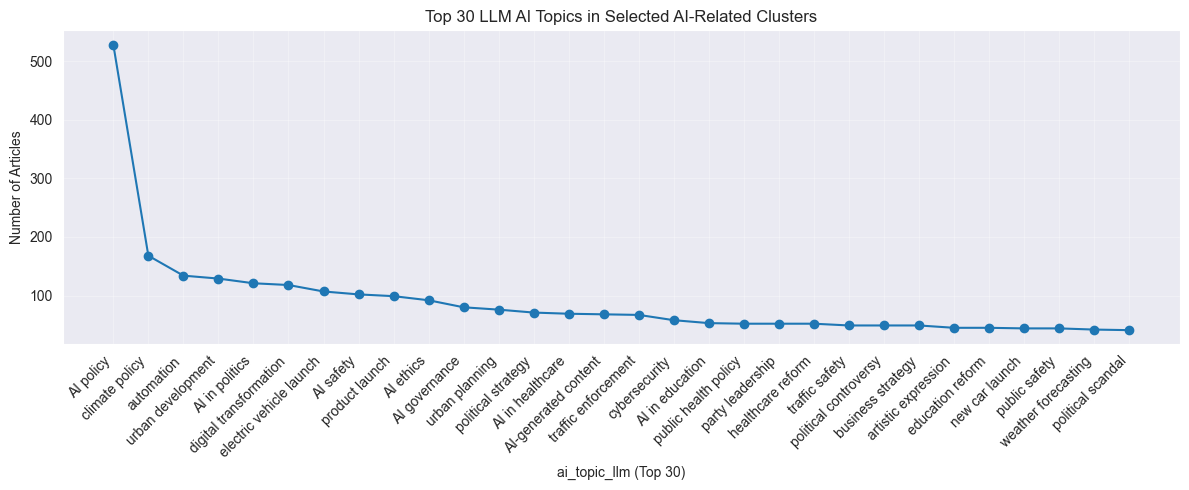

In [20]:
# keep only ai relative cluster
ai_relative_cluster = [
    "automation",
    "digital transformation",
    "AI policy",
    "electric vehicle launch",
    "AI in healthcare",
    "AI in politics",
    "AI product launch",
]
tmp_sb = sub2[sub2["cluster"].isin(ai_relative_cluster)].copy()

# ai_topic_llm distribution (Top 30)
tmp_topics = tmp_sb["ai_topic_llm"].value_counts().head(30)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tmp_topics.values, marker="o")
ax.set_xticks(range(len(tmp_topics)))
ax.set_xticklabels(tmp_topics.index, rotation=45, ha="right")

ax.set_title("Top 30 LLM AI Topics in Selected AI-Related Clusters")
ax.set_xlabel("ai_topic_llm (Top 30)")
ax.set_ylabel("Number of Articles")
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()


In [21]:
tmp_topics

ai_topic_llm
AI policy                  528
climate policy             168
automation                 134
urban development          129
AI in politics             121
digital transformation     118
electric vehicle launch    107
AI safety                  102
product launch              99
AI ethics                   92
AI governance               80
urban planning              76
political strategy          71
AI in healthcare            69
AI-generated content        68
traffic enforcement         67
cybersecurity               58
AI in education             53
public health policy        52
party leadership            52
healthcare reform           52
traffic safety              49
political controversy       49
business strategy           49
artistic expression         45
education reform            45
new car launch              44
public safety               44
weather forecasting         42
political scandal           41
Name: count, dtype: int64

In [22]:
# read embedding then select
target_df = tmp_sb
emb = np.load("../results/01_embeddings.npy")
# emb select by index base on sub2 orig_index column
emb = emb[tmp_sb['orig_index']]

In [23]:
barrier_queries = {
    "skills_gap": (
        "mangel på AI-kompetencer, mangel på tekniske færdigheder, "
        "utilstrækkelig ekspertise i data og machine learning, "
        "svært ved at rekruttere specialister, behov for efteruddannelse i AI"
    ),
    "resistance": (
        "medarbejdermodstand mod AI, frygt for automatisering, "
        "bekymring for at miste jobbet, modvilje mod digitale forandringer, "
        "kulturel modstand i organisationen"
    ),
    "privacy": (
        "databeskyttelse og privatliv, GDPR-bekymringer, "
        "persondata og følsomme oplysninger, krav til samtykke og lovlig behandling, "
        "risiko for datalæk og misbrug af personoplysninger"
    ),
    "data_quality": (
        "dårlig datakvalitet, ufuldstændige eller manglende data, "
        "inkonsistente datasæt, støj og fejl i registreringer, "
        "manglende datastandarder og governance"
    ),
    "ethics_bias": (
        "etiske problemer ved AI, algoritmisk bias, skævheder i data, "
        "u-retfærdig eller diskriminerende adfærd, "
        "bekymringer om ligebehandling og fairness"
    ),
    "transparency": (
        "manglende gennemsigtighed i modeller, black-box AI-systemer, "
        "svært at forklare beslutninger, mangel på forklarlighed og traceability, "
        "krav om dokumentation og audit af AI-løsninger"
    ),
}


sbert search for barrier type

In [24]:
barrier_texts = list(barrier_queries.values())
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

barrier_emb = model.encode(barrier_texts, normalize_embeddings=True)

# Compute similarity
barrier_scores = util.cos_sim(emb, barrier_emb).cpu().numpy()

# Assign label with maximum similarity, with tqdm progress bar
b_type = []
argmax_indices = barrier_scores.argmax(axis=1)
keys = list(barrier_queries.keys())
for idx in tqdm(argmax_indices, desc="Classifying Barriers", total=barrier_scores.shape[0]):
    b_type.append(keys[idx])

target_df["cos_barrier_type"] = b_type


Classifying Barriers: 100%|██████████| 30994/30994 [00:00<00:00, 2065825.36it/s]


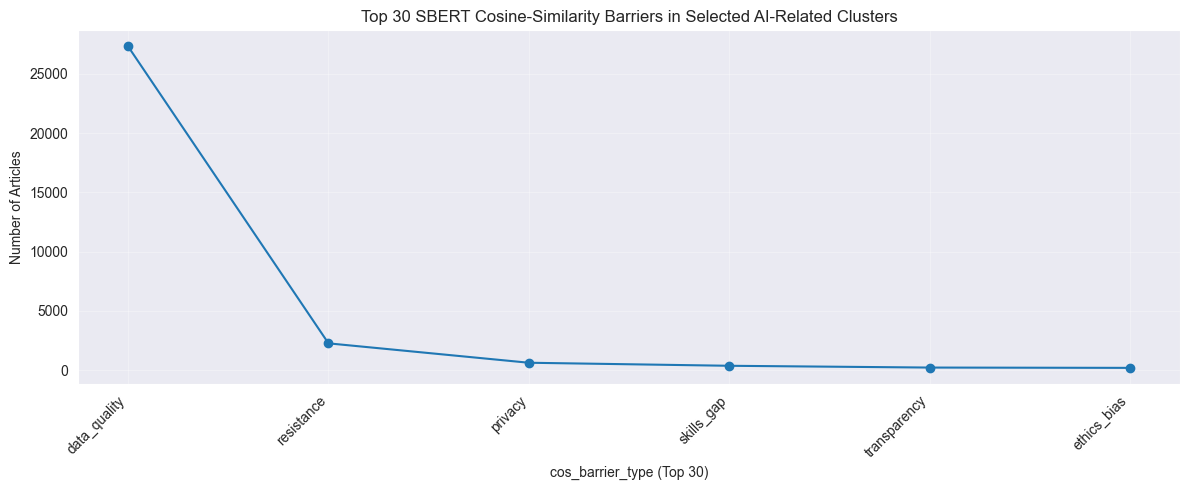

In [25]:
# distribution of cos_barrier_type

# ai_topic_llm distribution (Top 30)
tmp_bars = target_df["cos_barrier_type"].value_counts().head(30)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tmp_bars.values, marker="o")
ax.set_xticks(range(len(tmp_bars)))
ax.set_xticklabels(tmp_bars.index, rotation=45, ha="right")

ax.set_title("Top 30 SBERT Cosine-Similarity Barriers in Selected AI-Related Clusters")
ax.set_xlabel("cos_barrier_type (Top 30)")
ax.set_ylabel("Number of Articles")
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()



In [26]:
print(target_df.shape)
target_df['ai_barrier_type_llm'].value_counts()
print(5000/7)


(30994, 24)
714.2857142857143


In [27]:


BARRIER_COL = "ai_barrier_type_llm"   # free-text barrier label from LLM

labels_series = (
    target_df[BARRIER_COL]
    .astype(str)
    .str.strip()
    .str.lower()
)

# Define "no barrier" variants
no_barrier_tokens = {
    "none", # that's for sure
}

is_no_barrier = labels_series.isin(no_barrier_tokens)

# Keep only real barrier descriptions for clustering
labels_for_clustering = labels_series[~is_no_barrier].dropna()
labels_for_clustering = labels_for_clustering[labels_for_clustering != ""]

# prepare unique label
unique_labels = labels_for_clustering.unique().tolist()
# value counts
global_freq = labels_for_clustering.value_counts()




embeddings = model.encode(
    unique_labels,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
)

print("Embeddings shape:", embeddings.shape)

# ======================================
# 3. UMAP dimensionality reduction
#    (for clustering, not just visualization)
# ======================================

reducer = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=42,
)

embeddings_umap = reducer.fit_transform(embeddings)
print("Reduced embedding shape:", embeddings_umap.shape)

# ======================================
# 4. HDBSCAN clustering on UMAP space
# ======================================

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=20,         # tune: larger → fewer, more stable clusters
    min_samples=5,               # tune: noise vs tightness
    metric="euclidean",          # UMAP output is in Euclidean space
    cluster_selection_method="eom",
)

cluster_ids = clusterer.fit_predict(embeddings_umap)

n_clusters = len(set(cluster_ids)) - (1 if -1 in cluster_ids else 0)
print(f"HDBSCAN clusters (excluding noise): {n_clusters}")
print("Cluster label counts:", np.unique(cluster_ids, return_counts=True))

cluster_df = pd.DataFrame({
    "raw_label": unique_labels,
    "cluster_id": cluster_ids,
})

# ======================================
# 5. Choose representative label per cluster
# ======================================

def pick_representative_label(group: pd.DataFrame) -> str:
    """
    Pick a canonical label for a cluster:
    - highest global frequency first
    - then lexicographically
    """
    g = group.copy()
    g["freq"] = g["raw_label"].map(global_freq).fillna(0)
    g = g.sort_values(["freq", "raw_label"], ascending=[False, True])
    return g["raw_label"].iloc[0]

# Only for non-noise clusters (cluster_id != -1)
valid_clusters = cluster_df[cluster_df["cluster_id"] != -1]

cluster_repr = (
    valid_clusters
    .groupby("cluster_id")
    .apply(pick_representative_label)
    .rename("cluster_label")
    .reset_index()
)

# Merge representative labels back
cluster_df = cluster_df.merge(cluster_repr, on="cluster_id", how="left")

# Noise clusters (cluster_id == -1) get label "other"
cluster_df.loc[cluster_df["cluster_id"] == -1, "cluster_label"] = "other"

# Build mapping dicts: raw_label -> cluster_id / cluster_label
raw_to_cluster_id = dict(zip(cluster_df["raw_label"], cluster_df["cluster_id"]))
raw_to_cluster_label = dict(zip(cluster_df["raw_label"], cluster_df["cluster_label"]))

# ======================================
# 6. Map back to full df
# ======================================

target_df["barrier_label_raw"] = labels_series  # cleaned original

NO_BARRIER_CLUSTER_ID = -999
NO_BARRIER_CLUSTER_LABEL = "none"

def map_cluster_id(label: str):
    label = str(label).strip().lower()
    if label in no_barrier_tokens:
        return NO_BARRIER_CLUSTER_ID
    return raw_to_cluster_id.get(label, -1)  # -1 = HDBSCAN noise / unknown

def map_cluster_label(label: str):
    label = str(label).strip().lower()
    if label in no_barrier_tokens:
        return NO_BARRIER_CLUSTER_LABEL
    return raw_to_cluster_label.get(label, "other")

target_df["barrier_cluster_id"] = target_df["barrier_label_raw"].map(map_cluster_id)
target_df["barrier_cluster_label"] = target_df["barrier_label_raw"].map(map_cluster_label)

print(
    target_df[
        ["ai_barrier_type_llm",
         "barrier_label_raw",
         "barrier_cluster_id",
         "barrier_cluster_label"]
    ].head(20)
)

# ======================================
# 7. (Optional) Save cluster mapping for inspection
# ======================================

out_dir = "../results"
os.makedirs(out_dir, exist_ok=True)

cluster_dict_path = os.path.join(out_dir, "barrier_label_clusters_umap_hdbscan.csv")
cluster_df.to_csv(cluster_dict_path, index=False)
print("Saved barrier label cluster mapping to:", cluster_dict_path)


Batches: 100%|██████████| 5/5 [00:00<00:00, 25.40it/s]
E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Embeddings shape: (265, 768)
Reduced embedding shape: (265, 5)
HDBSCAN clusters (excluding noise): 6
Cluster label counts: (array([-1,  0,  1,  2,  3,  4,  5]), array([54, 27, 23, 25, 77, 27, 32]))
   ai_barrier_type_llm barrier_label_raw  barrier_cluster_id  \
1                 none              none                -999   
2                 none              none                -999   
3                 none              none                -999   
5                 none              none                -999   
7                 none              none                -999   
8                 none              none                -999   
9                 none              none                -999   
10                none              none                -999   
11                none              none                -999   
12                none              none                -999   
13                none              none                -999   
14                none            

E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\qswwq\AppData\Local\Temp\ipykernel_31932\3642193486.py:98: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_representative_label)


In [28]:
import umap
import numpy as np
import pandas as pd

# 2D UMAP for visualization
umap_vis = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.05,
    metric="cosine",
    random_state=42,
)
embeddings_2d = umap_vis.fit_transform(embeddings)  # shape (n_labels, 2)

# Attach coordinates to cluster_df
cluster_df["x"] = embeddings_2d[:, 0]
cluster_df["y"] = embeddings_2d[:, 1]

OUT_DIR = "../figures_barrier_clusters"
os.makedirs(OUT_DIR, exist_ok=True)

# Option A: color by numeric cluster_id
fig = px.scatter(
    cluster_df,
    x="x",
    y="y",
    color="cluster_id",
    hover_data={
        "raw_label": True,
        "cluster_id": True,
    },
    title="Barrier label clusters (UMAP 2D + HDBSCAN, colored by cluster_id)",
)
fig.update_traces(marker=dict(size=7, opacity=0.8))
fig.show()
fig.write_html(os.path.join(OUT_DIR, "barrier_clusters_by_id.html"))

# Option B: if you also have a human-readable cluster_label
if "cluster_label" in cluster_df.columns:
    fig2 = px.scatter(
        cluster_df,
        x="x",
        y="y",
        color="cluster_label",
        hover_data={
            "raw_label": True,
            "cluster_id": True,
            "cluster_label": True,
        },
        title="Barrier label clusters (UMAP 2D + HDBSCAN, colored by cluster_label)",
    )
    fig2.update_traces(marker=dict(size=7, opacity=0.8))
    fig2.show()
    fig2.write_html(os.path.join(OUT_DIR, "barrier_clusters_by_label.html"))


E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [29]:


barrier_counts = (
    target_df["barrier_cluster_label"]
    .astype(str)
    .str.strip()
    .replace("", "unknown")
    .value_counts()
    .reset_index()
)
barrier_counts.columns = ["barrier_cluster_label", "n_articles"]
barrier_counts = barrier_counts[
    ~barrier_counts["barrier_cluster_label"].isin(["other", "none"])
]
fig = px.bar(
    barrier_counts,
    x="barrier_cluster_label",
    y="n_articles",
    title="Distribution of barrier clusters across all articles",
)
fig.update_layout(
    xaxis_title="Barrier cluster label",
    yaxis_title="Number of articles",
    xaxis_tickangle=45,
)
fig.show()
fig.write_html(os.path.join(OUT_DIR, "02_barrier_cluster_distribution_articles.html"))



In [30]:
target_df

,plain_text,published_date,title,tags,categories,author,sitename,publisher,orig_index,is_ai_llm,...,year,is_ai_llm_flag,is_ai_flag,ai_barrier_llm_flag,cluster,cluster_kmeans,cos_barrier_type,barrier_label_raw,barrier_cluster_id,barrier_cluster_label
1,Lige siden den fjerde sæson af Skam blev bekræ...,2016-12-22,Her er vores bud på den næste hovedperson i Skam,jonas;magnus;even;isak;emma;sana;william;noora...,Kultur,NaN,Costume.dk,costume.dk,65,True,...,2016,True,NaN,False,AI policy,9,privacy,none,-999,none
2,Succes for ny vagtcentral Det tog tid at få g...,2016-12-22,Succes for ny vagtcentral,NaN,NaN,Jette Andersen,Sermitsiaq.AG,sermitsiaq.ag,117,True,...,2016,True,NaN,False,AI policy,1,data_quality,none,-999,none
3,Store Heddinge: Ældre Sagen Store Heddinge har...,2016-12-22,Lær om køb og brug af rejsekortet,rejsekort,Møder / Arrangementer,NaN,Stevnsbladet,stevnsbladet.dk,153,True,...,2016,True,NaN,False,AI policy,9,data_quality,none,-999,none
5,I weekenden slog Danmark endnu engang ny rekor...,2016-11-03,Hvornår får vi et indsamlingsshow til fordel f...,NaN,Tidsskriftet Outsideren,Tidsskriftet Outsideren,Outsideren,outsideren.dk,193,True,...,2016,True,NaN,False,AI in healthcare,0,resistance,none,-999,none
7,Du kender det. Fotovognen holder i vejsiden og...,2016-12-18,4. søndag i advent - Gaven der bliver ved at g...,ATK;Saphe,Baggrund,NaN,Online Bilmagasin med bilnyheder og biltests |...,bilsektionen.dk,249,True,...,2016,True,NaN,False,AI policy,9,data_quality,none,-999,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65361,"Debatten var krads, men opbakningen var klart ...",2020-10-15,Forslag vedtaget: Nu bliver der hejst regnbuef...,NaN,Samfund,NaN,TV2 ØSTJYLLAND,tv2ostjylland.dk,753440,True,...,2020,True,NaN,False,AI policy,9,data_quality,none,-999,none
65367,"Videooptagelser fra brystlommen, aflytning ved...",2020-09-23,Ny politiker står frem i Randers: Meldte modst...,NaN,Politik,NaN,TV2 ØSTJYLLAND,tv2ostjylland.dk,753640,True,...,2020,True,NaN,False,AI policy,1,data_quality,none,-999,none
65368,Selv om boligpriserne i den seneste periode ha...,2021-09-14,Københavnerbolig slår rekorden for dyreste lej...,NaN,Privatøkonomi,NaN,Politiken,politiken.dk,753720,True,...,2021,True,NaN,False,AI policy,10,data_quality,none,-999,none
65370,"Valgets tale er lysegrøn. Det står klart, efte...",2021-09-14,Arbejderpartiets drømmescenarie blev en realit...,NaN,Udland,Johan Varning Bendtsen,Kristeligt Dagblad,kristeligt-dagblad.dk,753756,True,...,2021,True,NaN,False,AI policy,9,data_quality,none,-999,none


In [31]:
df_plot = target_df.copy()
df_plot["barrier_cluster_label"] = (
    df_plot["barrier_cluster_label"]
    .astype(str)
    .str.strip()
    .replace("", "unknown")
)
df_plot = df_plot[
    ~df_plot["barrier_cluster_label"].isin(["other", "none"])
]

# Extract year from published_date (assuming it's a datetime or parseable string)
df_plot["year"] = pd.to_datetime(df_plot["published_date"]).dt.year

# Drop any rows with invalid years if needed (optional)
df_plot = df_plot.dropna(subset=["year"])
df_plot["year"] = df_plot["year"].astype(int)

# Count articles per year and per barrier cluster
counts = (
    df_plot.groupby(["year", "barrier_cluster_label"])
    .size()
    .reset_index(name="n_articles")
)

# Total articles per year
year_totals = counts.groupby("year")["n_articles"].sum().reset_index(name="total_per_year")

# Merge and compute percentage
counts = counts.merge(year_totals, on="year")
counts["percentage"] = (counts["n_articles"] / counts["total_per_year"]) * 100

# Create the plot: stacked bar chart is often best for showing ratios/proportions over time
fig = px.bar(
    counts,
    x="year",
    y="percentage",
    color="barrier_cluster_label",
    title="Percentage of articles per barrier cluster by year",
    labels={
        "percentage": "Percentage of articles (%)",
        "year": "Year",
        "barrier_cluster_label": "Barrier cluster label"
    },
    text="percentage",  # Optional: show percentages on bars
    barmode="stack"  # Stacked to visualize proportions (sums to 100% per year)
)

fig.update_traces(texttemplate="%{y:.1f}%", textposition="inside")
fig.update_layout(
    yaxis_title="Percentage of articles (%)",
    xaxis_title="Year",
    legend_title="Barrier cluster",
    xaxis={"type": "category"},  # Treat year as categorical to avoid gaps
    bargap=0.15
)

fig.show()

In [32]:

# Use the target DataFrame: target_df
df_plot = df.copy()

# Convert published_date to datetime and extract year
df_plot["published_date"] = pd.to_datetime(df_plot["published_date"])
df_plot["year"] = df_plot["published_date"].dt.year

# Drop invalid years (if any)
df_plot = df_plot.dropna(subset=["year"])
df_plot["year"] = df_plot["year"].astype(int)

# Create a readable label for is_ai_llm (assuming it's boolean, 0/1, or similar)
df_plot["category"] = df_plot["is_ai_llm"].apply(
    lambda x: "AI/LLM Related" if x else "Not AI/LLM"
)

# Counts by year and category
counts = (
    df_plot.groupby(["year", "category"])
    .size()
    .reset_index(name="n_articles")
)

# Total articles per year
year_totals = counts.groupby("year")["n_articles"].sum().reset_index(name="total_per_year")

# Merge and calculate percentage
counts = counts.merge(year_totals, on="year")
counts["percentage"] = (counts["n_articles"] / counts["total_per_year"]) * 100

# Plot 1: Percentage of AI/LLM articles by year (stacked bar, sums to 100%)
fig_pct = px.bar(
    counts,
    x="year",
    y="percentage",
    color="category",
    title="Percentage of AI/LLM-related articles by year (target_df)",
    labels={
        "percentage": "Percentage of articles (%)",
        "year": "Year",
        "category": "Article Type"
    },
    barmode="stack",
    color_discrete_sequence=["#ff7f0e", "#1f77b4"]  # Orange for AI, blue for non-AI
)

fig_pct.update_traces(texttemplate="%{y:.1f}%", textposition="inside")
fig_pct.update_layout(
    yaxis_title="Percentage (%)",
    xaxis_title="Year",
    legend_title="Article Type",
    xaxis={"type": "category"},
    bargap=0.15
)

fig_pct.show()
fig_pct.write_html(os.path.join(OUT_DIR, "04_ai_llm_percentage_by_year.html"))

# Plot 2: Absolute number of articles by year (stacked bar)
fig_count = px.bar(
    counts,
    x="year",
    y="n_articles",
    color="category",
    title="Number of AI/LLM-related articles by year (target_df)",
    labels={
        "n_articles": "Number of articles",
        "year": "Year",
        "category": "Article Type"
    },
    barmode="stack",
    color_discrete_sequence=["#ff7f0e", "#1f77b4"]
)

fig_count.update_layout(
    yaxis_title="Number of articles",
    xaxis_title="Year",
    legend_title="Article Type",
    xaxis={"type": "category"}
)

fig_count.show()
fig_count.write_html(os.path.join(OUT_DIR, "05_ai_llm_counts_by_year.html"))

In [33]:
# topic and barrier 2D compare plot
df_plot = target_df.copy()

# Clean topic and barrier labels
df_plot["ai_topic_llm"] = (
    df_plot["ai_topic_llm"]
    .astype(str)
    .str.strip()
    .replace("", "unknown")
)

df_plot["barrier_cluster_label"] = (
    df_plot["barrier_cluster_label"]
    .astype(str)
    .str.strip()
    .replace("", "unknown")
)

# Remove aggregated / non-informative labels
df_plot = df_plot[
    ~df_plot["barrier_cluster_label"].isin(["other", "none", "unknown"])
]

# Optional: also drop unknown topics
df_plot = df_plot[df_plot["ai_topic_llm"] != "unknown"]

# Limit to top topics / top barriers to keep plot readable
TOPK_TOPICS = 20
TOPK_BARRIERS = 10

top_topics = (
    df_plot["ai_topic_llm"]
    .value_counts()
    .head(TOPK_TOPICS)
    .index
)

top_barriers = (
    df_plot["barrier_cluster_label"]
    .value_counts()
    .head(TOPK_BARRIERS)
    .index
)

df_plot = df_plot[
    df_plot["ai_topic_llm"].isin(top_topics)
    & df_plot["barrier_cluster_label"].isin(top_barriers)
]

# ============================================================
# 2. Topic × barrier table (counts + row %)
# ============================================================

# Cross-tab: counts
ct = pd.crosstab(
    df_plot["ai_topic_llm"],
    df_plot["barrier_cluster_label"]
)

# Row-normalised percentages (share of barriers *within each topic*)
ct_row_pct = ct.div(ct.sum(axis=1), axis=0) * 100

# Long-format table (if you want to export / inspect)
topic_barrier_long = (
    ct
    .stack()
    .reset_index(name="n_articles")
    .rename(columns={"ai_topic_llm": "topic", "barrier_cluster_label": "barrier"})
)

topic_barrier_long["row_pct"] = (
    topic_barrier_long["n_articles"]
    / topic_barrier_long.groupby("topic")["n_articles"].transform("sum")
    * 100
)

print("\n=== Topic × Barrier: counts (Top topics/barriers) ===")
print(ct)

print("\n=== Topic × Barrier: row-normalised % ===")
print(ct_row_pct.round(1))

# Optional: save tables
os.makedirs("../results", exist_ok=True)
ct.to_csv("results/topic_barrier_counts.csv")
ct_row_pct.to_csv("results/topic_barrier_row_pct.csv")

# ============================================================
# 3. 2D heatmap: topic vs barrier (row %)
# ============================================================

fig = px.imshow(
    ct_row_pct,
    x=ct_row_pct.columns,
    y=ct_row_pct.index,
    text_auto=".1f",
    aspect="auto",
    labels=dict(
        x="Barrier cluster label",
        y="AI topic (ai_topic_llm)",
        color="Share within topic (%)",
    ),
    title="Barrier distribution within AI topics (row-normalised %)",
)

# If you prefer the x-axis at bottom, comment out the next line
# fig.update_xaxes(side="top")

fig.update_layout(
    xaxis_tickangle=45,
)

fig.show()
fig.write_html("results/topic_barrier_heatmap_row_pct.html")

# ============================================================
# (Optional) 2D heatmap with raw counts instead of %
# ============================================================

fig_counts = px.imshow(
    ct,
    x=ct.columns,
    y=ct.index,
    text_auto=True,
    aspect="auto",
    labels=dict(
        x="Barrier cluster label",
        y="AI topic (ai_topic_llm)",
        color="Number of articles",
    ),
    title="Barrier counts within AI topics (raw counts)",
)

fig_counts.update_layout(
    xaxis_tickangle=45,
)

fig_counts.show()


=== Topic × Barrier: counts (Top topics/barriers) ===
barrier_cluster_label       cost  data privacy concerns  regulation  \
ai_topic_llm                                                          
AI adoption in business        0                      0           0   
algorithmic bias               0                      0           0   
automation                     0                      0           1   
autonomous buses               0                      0           2   
autonomous driving             0                      0           2   
autonomous shuttles            0                      0           2   
autonomous vehicle testing     0                      0           1   
autonomous vehicles            0                      0           2   
cybersecurity training         0                      0           0   
digital identity               1                      2           0   
digital transformation         2                      1           0   
electric vehicle adopt